In [1]:
from copy import deepcopy
import os
import sys
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

from scipy.optimize import basinhopping, minimize
from scipy.stats import chisquare

sys.path.append(os.path.dirname(sys.path[0]))

In [3]:
from rmo import RadialMovementOptimization
import scripts.constants as con
from scripts.helpers import get_unique_frame
from scripts.plotter import Plotter, get_temperature_legend
from scripts.properties.ovito_procedures import OvitoProcessor
from scripts.rdf_calculator import RDFCalculator

In [4]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14

In [5]:
np.random.seed(0)

In [6]:
@njit
def math_round(value):
    rest = value - int(value)
    if rest >= 0.5 and value >= 0:
        return float(int(value) + 1)
    if rest <= -0.5 and value < 0:
        return float(int(value) - 1)
    return float(int(value))

@njit
def get_boundary_conditions(
        cell_dimensions: np.ndarray,
        particles_number: int,
        positions: np.ndarray,
):
    for i in range(particles_number):
        for j in range(3):
            if positions[i][j] >= cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
            if positions[i][j] < -cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
    return positions

In [7]:
def calculate_rdf(positions):
    cell_dimensions = np.array([12.25, 12.25, 12.25])
    radii, rdf = OvitoProcessor(
        positions=positions, 
        cell_dimensions=cell_dimensions,
    ).get_rdf()
    return radii, rdf

In [8]:
def mse(obs, exp):
    return np.sum((obs - exp) ** 2)

In [9]:
def generate_random_state() -> None:
    particles_number = 1372
    cell_dimensions = 12.25 * np.ones(3)
    return (np.random.random((particles_number, 3)) - 0.5) * cell_dimensions

In [10]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'hooke_jeeves_minimization'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_NORMAL)

PATH_TO_CURRENT_DATA_NORMAL

'D:\\albert\\programming\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [11]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))
cooled_1 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_1.npy'))
cooled_2 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_2.npy'))

samples.shape, test_sample.shape, targets.shape, cooled_1.shape, cooled_2.shape

((2464, 612), (1, 612), (2464, 1372, 3), (1372, 3), (1372, 3))

In [12]:
i = 1
obs_rdf = samples[i]
some_positions = targets[-i]
# some_positions = generate_random_state()
some_positions.shape

(1372, 3)

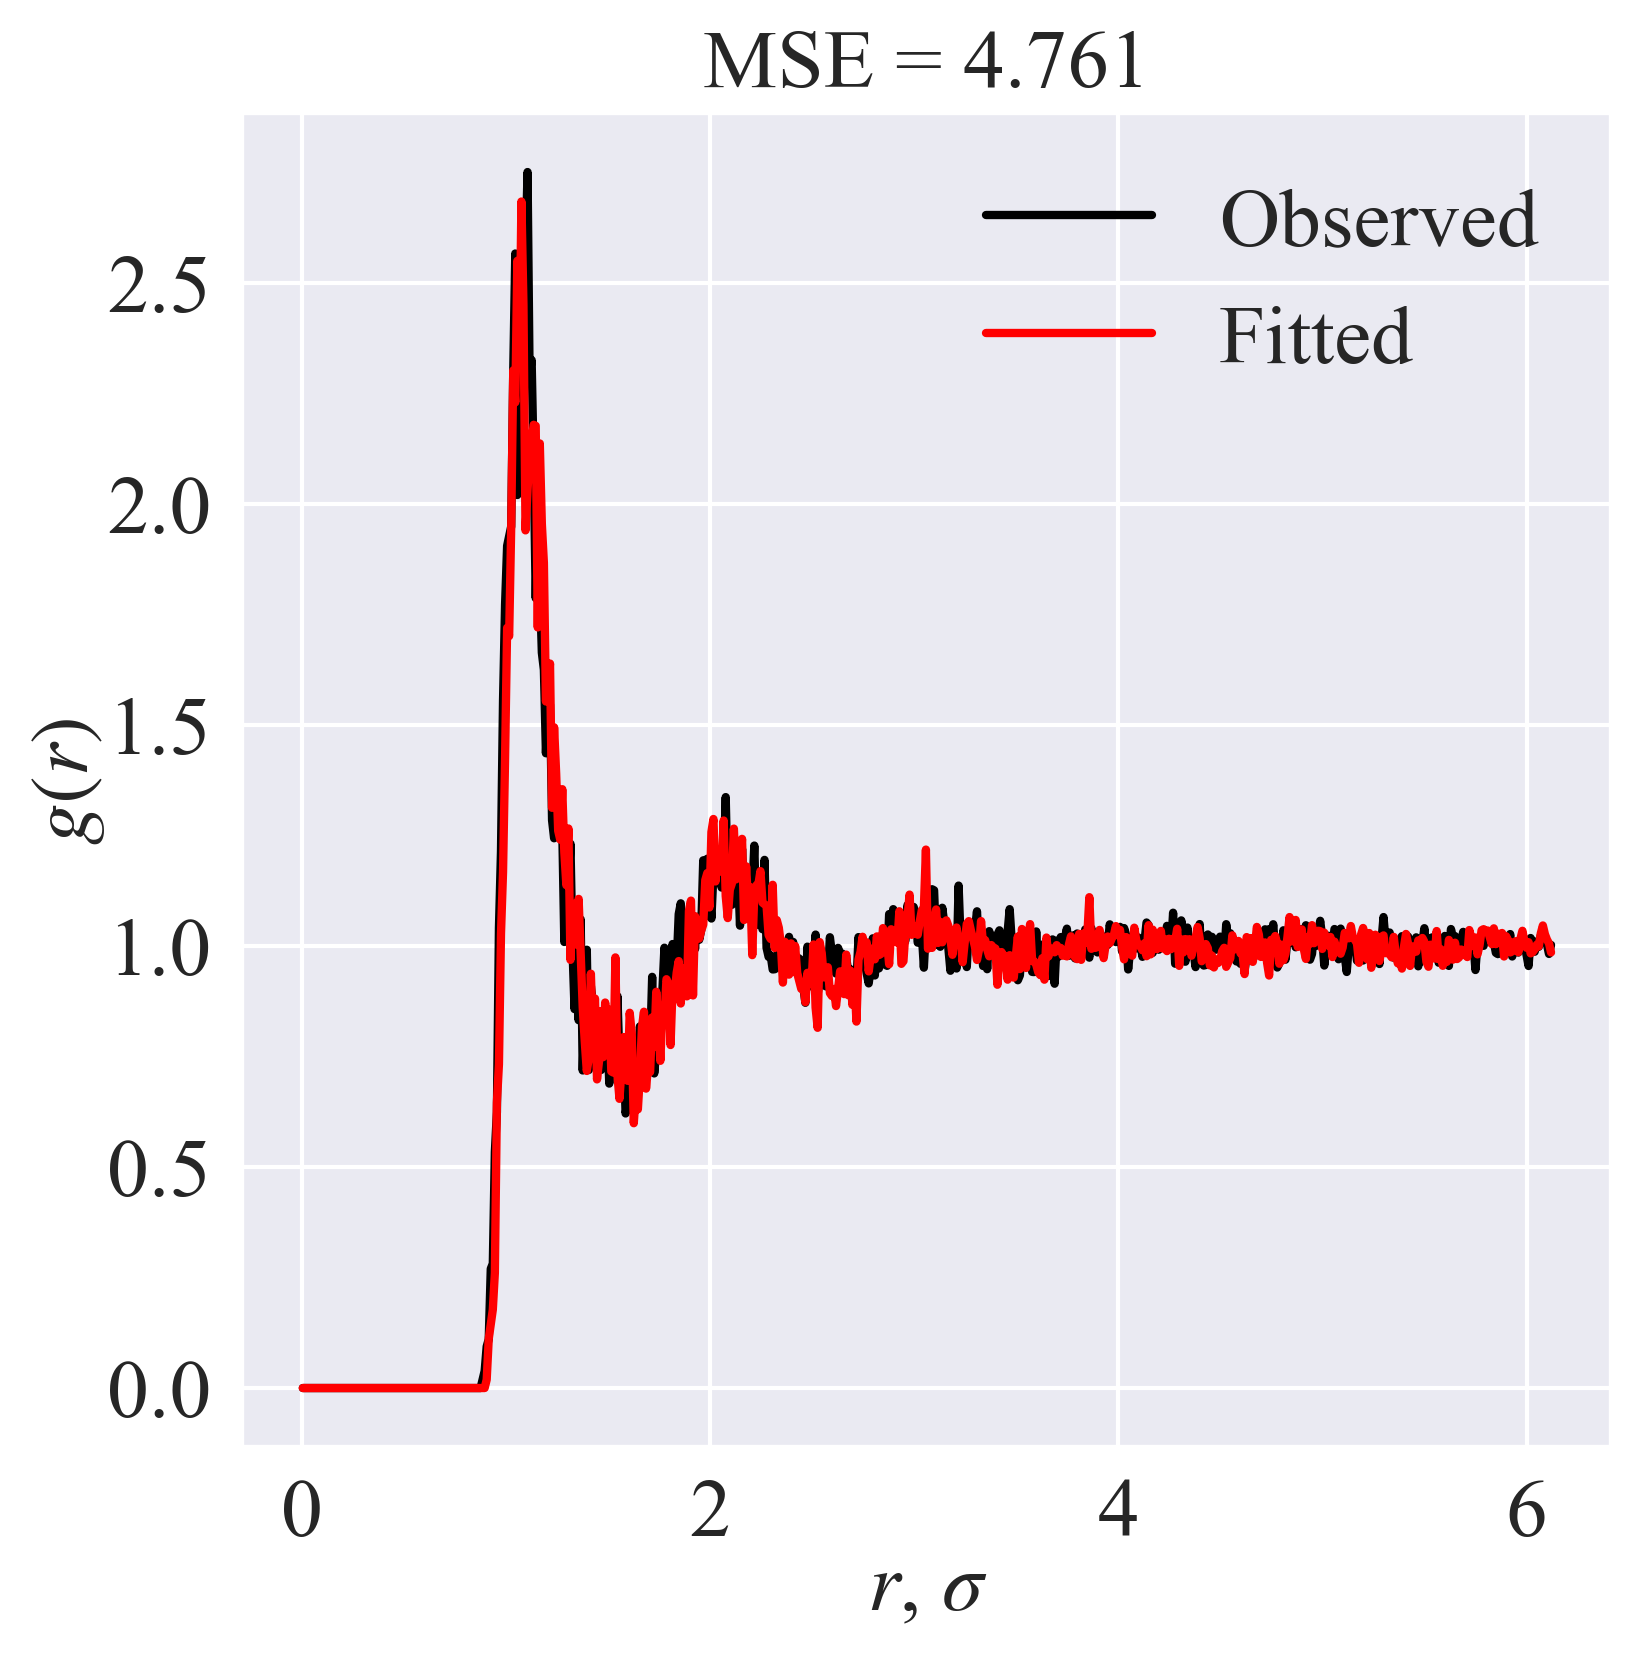

In [13]:
radii, exp_rdf = calculate_rdf(some_positions)
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('initial_state_local.png')
plt.show()

In [14]:
cell_dimensions = np.ones(3) * 12.25

In [15]:
def optimized_func(positions):
    collided_number = 0
    positions = positions.reshape(1372, 3)
    radii, exp_rdf = calculate_rdf(positions)
    size = obs_rdf.size
    radii = radii[:size]
    exp_rdf = exp_rdf[:size]
    if np.where(exp_rdf > 0)[0][0] < np.where(obs_rdf > 0)[0][0]:
        collided_number = exp_rdf[np.where(exp_rdf > 0)[0]].sum()
    result = mse(obs=obs_rdf, exp=exp_rdf)
    return result, collided_number

In [16]:
def hooke_jeeves_minimization(
        optimized,
        function: callable,
        accuracy,
        step: float,
        minimized_index: int
):
    old_result = function(optimized)
    new_result = np.array(old_result)
    mse_values = [old_result[0]]
    parameters_array = [np.array(optimized)]
    outer_step_number = 1
    while step > accuracy:
        inner_start = datetime.now()
        print(f'{outer_step_number = }')
        print(f'{step = }')
        x_old = np.array(optimized)
        for i in range(optimized.shape[0]):
            if i % 100 == 0:
                print(f'{i}/{optimized.shape[0]} particles are processed at step {outer_step_number}...')
                
            for j in range(optimized.shape[1]):
                _steps = np.zeros(optimized.shape)
                _steps[i][j] += step
                new_result = function(optimized + _steps)
                
                if minimized_index == -1:
                    if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                else:
                    if (new_result[minimized_index] < old_result[minimized_index]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[minimized_index] < old_result[minimized_index]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                print(new_result)
            
        x_new = np.array(optimized)
        optimized = x_old + 2 * (x_new - x_old)
        old_result = function(optimized)
        if old_result[0] >= new_result[0]:
            optimized = np.array(x_new)
            old_result = np.array(new_result)
            step = step / 5
        outer_step_number += 1
        mse_values.append(old_result[0])
        parameters_array.append(np.array(optimized))
        print(f'Current MSE = {old_result[0]}')
        if len(mse_values) > 2 and mse_values[-1] == mse_values[-2]:
            break
        print(f'{datetime.now() - inner_start = }')
    return optimized, mse_values, parameters_array

In [17]:
# def hooke_jeeves_minimization(
#         optimized,
#         function: callable,
#         accuracy,
#         step: float,
#         minimized_index: int
# ):
#     old_result = function(optimized)
#     new_result = np.array(old_result)
#     mse_values = [old_result[0]]
#     parameters_array = [np.array(optimized)]
#     outer_step_number = 1
#     is_break = False
#     while not is_break:
#         inner_start = datetime.now()
#         print(f'{outer_step_number = }')
#         print(f'{step = }')
#         x_old = np.array(optimized)
#         for i in range(optimized.shape[0]):
#             if i % 100 == 0:
#                 print(f'{i}/{optimized.shape[0]} particles are processed at step {outer_step_number}...')
                
#             for j in range(optimized.shape[1]):
#                 _steps = np.zeros(optimized.shape)
#                 _steps[i][j] += np.random.rand() * 12.25
#                 new_result = function(optimized + _steps)
#                 if minimized_index == -1:
#                     if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
#                         optimized += _steps
#                         old_result = np.array(new_result)
#                     else:
#                         new_result = function(optimized - _steps)
#                         if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
#                             optimized -= _steps
#                             old_result = np.array(new_result)
#                         else:
#                             new_result = np.array(old_result)
#                 else:
#                     if (new_result[minimized_index] < old_result[minimized_index]):
#                         optimized += _steps
#                         old_result = np.array(new_result)
#                     else:
#                         new_result = function(optimized - _steps)
#                         if (new_result[minimized_index] < old_result[minimized_index]):
#                             optimized -= _steps
#                             old_result = np.array(new_result)
#                         else:
#                             new_result = np.array(old_result)
#                 print(new_result)
            
#         x_new = np.array(optimized)
#         optimized = x_old + 2 * (x_new - x_old)
#         old_result = function(optimized)
#         if old_result[0] >= new_result[0]:
#             optimized = np.array(x_new)
#             old_result = np.array(new_result)
#             step = step / 5
#         outer_step_number += 1
#         mse_values.append(old_result[0])
#         parameters_array.append(np.array(optimized))
#         print(f'Current MSE = {old_result[0]}')
#         if minimized_index == -1:
#             is_break = old_result[0] < accuracy
#         else:
#             is_break = old_result[minimized_index] < accuracy
#         if len(mse_values) > 2 and mse_values[-1] == mse_values[-2]:
#             break
#         print(f'{datetime.now() - inner_start = }')
#     return optimized, mse_values, parameters_array

In [18]:
def interruption_proof_minimization(minimization_method, args, **kwargs):
    outer_start = datetime.now()
    optimized = np.array(args)
    try:
        optimized, mse_values, parameters_array = minimization_method(optimized, **kwargs)
        print(mse_values)
    except (KeyboardInterrupt, SystemError):
        return optimized, [], [np.array(optimized)]
    print(f'{datetime.now() - outer_start = }')
    return optimized, mse_values, parameters_array

In [19]:
new_positions, mse_values, parameters_array = interruption_proof_minimization(
    minimization_method=hooke_jeeves_minimization,
    args=some_positions,
    function=optimized_func,
    accuracy=1e-11,
    step=0.01,
    minimized_index=0,
)

outer_step_number = 1
step = 0.01
0/1372 particles are processed at step 1...
(4.738677122686418, 0)
[4.73867712 0.        ]
(4.709499796231204, 0)
(4.685358768059865, 0)
[4.68535877 0.        ]
[4.68535877 0.        ]
(4.677627406830291, 0)
(4.659479912716307, 0)
[4.65947991 0.        ]
(4.658555515006652, 0)
(4.652257190704082, 0)
(4.64605044227207, 0)
(4.600023780573528, 0)
(4.586243583301129, 0)
[4.58624358 0.        ]
(4.5710392517829455, 0)
(4.570113795083083, 0)
(4.565267038646796, 0)
[4.56526704 0.        ]
(4.560129519534947, 0)
(4.557797987933824, 0)
(4.553365728438441, 0)
(4.536179820657185, 0)
(4.5319511133677555, 0)
(4.530898863062174, 0)
(4.523339067276471, 0)
(4.521531579436221, 0)
(4.514790213655148, 0)
(4.509878861557334, 0)
[4.50987886 0.        ]
(4.47834013310484, 0)
[4.47834013 0.        ]
[4.47834013 0.        ]
(4.476045193924033, 0)
[4.47604519 0.        ]
[4.47604519 0.        ]
[4.47604519 0.        ]
(4.464331824781929, 0)
[4.46433182 0.        ]
(4.456895982

[3.17389743 0.        ]
(3.1732036428098165, 0)
[3.17320364 0.        ]
(3.1716588636554928, 0)
[3.17165886 0.        ]
[3.17165886 0.        ]
[3.17165886 0.        ]
(3.1700097986328144, 0)
(3.1696195599384764, 0)
(3.1692946111667313, 0)
(3.151341930500518, 0)
(3.1489830900322087, 0)
(3.139936381798251, 0)
(3.1154445430253954, 0)
[3.11544454 0.        ]
[3.11544454 0.        ]
(3.112172695159143, 0)
[3.1121727 0.       ]
[3.1121727 0.       ]
(3.1109109771929955, 0)
(3.1064705683591, 0)
(3.1038202294672272, 0)
[3.10382023 0.        ]
(3.103299698997482, 0)
(3.0968949672459383, 0)
(3.092837296702942, 0)
[3.0928373 0.       ]
[3.0928373 0.       ]
(3.0905224007652308, 0)
[3.0905224 0.       ]
(3.0791268153427422, 0)
[3.07912682 0.        ]
[3.07912682 0.        ]
(3.0659246888010094, 0)
(3.059100682826332, 0)
(3.0503945754257664, 0)
[3.05039458 0.        ]
(3.049224695301347, 0)
[3.0492247 0.       ]
(3.0491525855518686, 0)
(3.0469377189659754, 0)
(3.0410385910833524, 0)
(3.03526911273

(2.2551862137816565, 0)
[2.25518621 0.        ]
(2.2502163603315, 0)
[2.25021636 0.        ]
(2.2413375167785374, 0)
(2.2229993180868535, 0)
[2.22299932 0.        ]
[2.22299932 0.        ]
(2.221168733229528, 0)
[2.22116873 0.        ]
[2.22116873 0.        ]
[2.22116873 0.        ]
[2.22116873 0.        ]
(2.2188879187909936, 0)
(2.205873234509613, 0)
(2.1983956679554826, 0)
[2.19839567 0.        ]
(2.197099052137033, 0)
[2.19709905 0.        ]
(2.1927343262973804, 0)
(2.184416094554236, 0)
[2.18441609 0.        ]
[2.18441609 0.        ]
[2.18441609 0.        ]
[2.18441609 0.        ]
[2.18441609 0.        ]
(2.1792651939446195, 0)
[2.17926519 0.        ]
(2.1714033273840676, 0)
(2.1661235537482604, 0)
[2.16612355 0.        ]
[2.16612355 0.        ]
[2.16612355 0.        ]
(2.1637413691722838, 0)
(2.1624428433900205, 0)
(2.157054205391054, 0)
(2.152243493294763, 0)
(2.1497197565184116, 0)
[2.14971976 0.        ]
(2.1423758620421705, 0)
[2.14237586 0.        ]
[2.14237586 0.        ]
[

(1.6999627346402995, 0)
[1.69996273 0.        ]
[1.69996273 0.        ]
[1.69996273 0.        ]
(1.699379304941377, 0)
(1.6983319912343622, 0)
[1.69833199 0.        ]
[1.69833199 0.        ]
(1.6950795631659594, 0)
[1.69507956 0.        ]
[1.69507956 0.        ]
[1.69507956 0.        ]
[1.69507956 0.        ]
(1.6940732580278197, 0)
[1.69407326 0.        ]
[1.69407326 0.        ]
[1.69407326 0.        ]
[1.69407326 0.        ]
(1.6938219728825574, 0)
[1.69382197 0.        ]
[1.69382197 0.        ]
[1.69382197 0.        ]
[1.69382197 0.        ]
(1.6920458217747862, 0)
(1.68644295330202, 0)
(1.6847378014473506, 0)
[1.6847378 0.       ]
(1.6814995330047848, 0)
[1.68149953 0.        ]
[1.68149953 0.        ]
[1.68149953 0.        ]
(1.6809307158907005, 0)
[1.68093072 0.        ]
(1.6790268992688575, 0)
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.       ]
[1.6790269 0.

[1.42506539 0.        ]
(1.4222122302044782, 0)
[1.42221223 0.        ]
[1.42221223 0.        ]
(1.416604033454202, 0)
(1.4159061350998337, 0)
(1.414413744488451, 0)
[1.41441374 0.        ]
[1.41441374 0.        ]
(1.4119149008309688, 0)
(1.4092761348417389, 0)
(1.4092148947748477, 0)
(1.4080695084616877, 0)
(1.408022610620805, 0)
[1.40802261 0.        ]
(1.407661462720133, 0)
(1.4065265590463127, 0)
(1.4036741012197214, 0)
[1.4036741 0.       ]
(1.3998731927480856, 0)
[1.39987319 0.        ]
[1.39987319 0.        ]
[1.39987319 0.        ]
(1.3996355382287544, 0)
[1.39963554 0.        ]
[1.39963554 0.        ]
(1.3978936087460228, 0)
[1.39789361 0.        ]
[1.39789361 0.        ]
[1.39789361 0.        ]
[1.39789361 0.        ]
(1.3955038471748296, 0)
[1.39550385 0.        ]
[1.39550385 0.        ]
(1.3953827236917884, 0)
[1.39538272 0.        ]
[1.39538272 0.        ]
[1.39538272 0.        ]
(1.3925921607346896, 0)
(1.3915887312821704, 0)
[1.39158873 0.        ]
(1.3913990793932187, 0

[1.26471309 0.        ]
[1.26471309 0.        ]
(1.2633724181137742, 0)
[1.26337242 0.        ]
(1.2596981623898822, 0)
(1.2578992906429236, 0)
[1.25789929 0.        ]
(1.257870686763345, 0)
[1.25787069 0.        ]
[1.25787069 0.        ]
[1.25787069 0.        ]
(1.2559626428298554, 0)
(1.255054467618264, 0)
(1.2537724659088787, 0)
[1.25377247 0.        ]
[1.25377247 0.        ]
[1.25377247 0.        ]
[1.25377247 0.        ]
[1.25377247 0.        ]
(1.2534986101946441, 0)
[1.25349861 0.        ]
[1.25349861 0.        ]
[1.25349861 0.        ]
[1.25349861 0.        ]
(1.2491582090135571, 0)
[1.24915821 0.        ]
[1.24915821 0.        ]
(1.248679117139337, 0)
[1.24867912 0.        ]
[1.24867912 0.        ]
(1.2469564225538052, 0)
[1.24695642 0.        ]
[1.24695642 0.        ]
(1.2424617353131573, 0)
[1.24246174 0.        ]
(1.242022690475614, 0)
[1.24202269 0.        ]
(1.2405064104550036, 0)
[1.24050641 0.        ]
(1.2403595720410847, 0)
[1.24035957 0.        ]
[1.24035957 0.      

[1.11473115 0.        ]
[1.11473115 0.        ]
[1.11473115 0.        ]
[1.11473115 0.        ]
[1.11473115 0.        ]
[1.11473115 0.        ]
[1.11473115 0.        ]
[1.11473115 0.        ]
(1.1147295062608706, 0)
[1.11472951 0.        ]
(1.1144405183702695, 0)
(1.1102841910674344, 0)
[1.11028419 0.        ]
[1.11028419 0.        ]
[1.11028419 0.        ]
[1.11028419 0.        ]
(1.1099587691789379, 0)
[1.10995877 0.        ]
[1.10995877 0.        ]
[1.10995877 0.        ]
[1.10995877 0.        ]
[1.10995877 0.        ]
(1.1096474812053456, 0)
[1.10964748 0.        ]
[1.10964748 0.        ]
[1.10964748 0.        ]
[1.10964748 0.        ]
[1.10964748 0.        ]
[1.10964748 0.        ]
(1.10892217654261, 0)
[1.10892218 0.        ]
[1.10892218 0.        ]
(1.10806360348372, 0)
[1.1080636 0.       ]
[1.1080636 0.       ]
(1.1077664767297146, 0)
700/1372 particles are processed at step 1...
[1.10776648 0.        ]
(1.107007978331234, 0)
[1.10700798 0.        ]
(1.1055073415035008, 0)
[1.

[1.02698888 0.        ]
[1.02698888 0.        ]
[1.02698888 0.        ]
[1.02698888 0.        ]
[1.02698888 0.        ]
[1.02698888 0.        ]
(1.0269196834321495, 0)
[1.02691968 0.        ]
(1.0261049396453816, 0)
[1.02610494 0.        ]
[1.02610494 0.        ]
[1.02610494 0.        ]
[1.02610494 0.        ]
[1.02610494 0.        ]
[1.02610494 0.        ]
[1.02610494 0.        ]
[1.02610494 0.        ]
(1.0236569222499743, 0)
[1.02365692 0.        ]
[1.02365692 0.        ]
(1.0228751594554724, 0)
[1.02287516 0.        ]
[1.02287516 0.        ]
[1.02287516 0.        ]
[1.02287516 0.        ]
[1.02287516 0.        ]
(1.0206016095756847, 0)
[1.02060161 0.        ]
[1.02060161 0.        ]
[1.02060161 0.        ]
[1.02060161 0.        ]
[1.02060161 0.        ]
[1.02060161 0.        ]
(1.0193001400747217, 0)
[1.01930014 0.        ]
[1.01930014 0.        ]
(1.0190088611319257, 0)
[1.01900886 0.        ]
[1.01900886 0.        ]
[1.01900886 0.        ]
(1.0177518880522647, 0)
(1.0172136593139

[0.9543191 0.       ]
[0.9543191 0.       ]
[0.9543191 0.       ]
[0.9543191 0.       ]
[0.9543191 0.       ]
[0.9543191 0.       ]
[0.9543191 0.       ]
[0.9543191 0.       ]
(0.9519170186594537, 0)
(0.9510429138774655, 0)
[0.95104291 0.        ]
[0.95104291 0.        ]
(0.9501712009639841, 0)
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
[0.9501712 0.       ]
(0.9498700933212357, 0)
(0.9470749565141499, 0)
(0.9467670378345411, 0)
(0.9463755032137708, 0)
(0.9442634778584128, 0)
[0.94426348 0.        ]
[0.94426348 0.        ]
[0.94426348 0.        ]
[0.94426348 0.        ]
(0.9439098615895364, 0)
[0.94390986 0.        ]
[0.94390986 0.        ]
(0.943531203424703, 0)
[0.9435312 0.       ]
[0.9435312 0.       ]
[0.9435312 0.       ]
(0.9432362269928901, 0)
[0.94323623 0.        ]
[0.94323623 0.        ]
(0.9429114021900202, 0)
[0.9429114 

(0.8783762358681536, 0)
[0.87837624 0.        ]
[0.87837624 0.        ]
[0.87837624 0.        ]
[0.87837624 0.        ]
[0.87837624 0.        ]
(0.8782698254782455, 0)
[0.87826983 0.        ]
[0.87826983 0.        ]
[0.87826983 0.        ]
[0.87826983 0.        ]
[0.87826983 0.        ]
(0.8770648908182623, 0)
(0.8752938849338407, 0)
[0.87529388 0.        ]
[0.87529388 0.        ]
[0.87529388 0.        ]
[0.87529388 0.        ]
[0.87529388 0.        ]
[0.87529388 0.        ]
[0.87529388 0.        ]
[0.87529388 0.        ]
(0.874701515736744, 0)
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
[0.87470152 0.        ]
(0.8745283987953794, 0)
[0.8745284 0.       ]
(0.8742756451603932, 0)
(0.8737688906859042, 0)
[0.87376889 0.     

[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
[0.83282527 0.        ]
(0.8325104242537994, 0)
(0.832069230944141, 0)
[0.83206923 0.        ]
[0.83206923 0.        ]
(0.830879353769186, 0)
[0.83087935 0.        ]
[0.83087935 0.        ]
[0.83087935 0.        ]
[0.83087935 0.        ]
[0.83087935 0.        ]
[0.83087935 0.        ]
[0.83087935 0.        ]
[0.83087935 0.        ]
(0.830513363874064, 0)
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
[0.83051336 0.        ]
(0.8302511155953223, 0)
[0.83025112 0.        ]
[0.83025112 0.        ]
[0.83025112 0.        ]
[0.83025112 0.        ]
(0.829636701976856, 0)
(0.8290605545330587,

[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
[0.80208681 0.        ]
(0.8019518029347128, 0)
(0.8011209810992841, 0)
(0.8008527977289117, 0)
[0.8008528 0.       ]
[0.8008528 0.       ]
[0.8008528 0.       ]
(0.7993815052166324, 0)
(0.7976038324152648, 0)
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
[0.79760383 0.        ]
(0.796468035644376, 0)
[0.79646804 0.        ]
[0.79646804 0.        ]
[0.79646804 0.        ]
[0.79646804 0.        ]
[0.79646804 0.        ]
[0.79646804 0.        ]
[0.79646804 0.        ]
[0.79646804 0.        ]

[0.77705525 0.        ]
(0.7768644292884767, 0)
[0.77686443 0.        ]
[0.77686443 0.        ]
(0.7767975292246249, 0)
(0.7763391413599185, 0)
(0.775813567573536, 0)
(0.7756026281701788, 0)
(0.7755596409324501, 0)
[0.77555964 0.        ]
(0.7752537200952654, 0)
(0.7749780594118869, 0)
(0.7741276139732484, 0)
(0.7738659970115707, 0)
[0.773866 0.      ]
[0.773866 0.      ]
(0.7736338623670291, 0)
[0.77363386 0.        ]
[0.77363386 0.        ]
[0.77363386 0.        ]
(0.773184096300969, 0)
(0.7723018877681016, 0)
[0.77230189 0.        ]
(0.7722979825522096, 0)
(0.772081536200808, 0)
(0.7713186399253964, 0)
(0.7713115807441717, 0)
[0.77131158 0.        ]
[0.77131158 0.        ]
[0.77131158 0.        ]
(0.7706827784148194, 0)
[0.77068278 0.        ]
(0.7703170842872801, 0)
(0.770156556772509, 0)
[0.77015656 0.        ]
(0.7701505196575731, 0)
[0.77015052 0.        ]
[0.77015052 0.        ]
[0.77015052 0.        ]
(0.769489977953775, 0)
[0.76948998 0.        ]
[0.76948998 0.        ]
[0.76

[0.74192436 0.        ]
(0.7415988595568767, 0)
(0.7415796260483942, 0)
(0.7415434320170488, 0)
[0.74154343 0.        ]
(0.7413277709203823, 0)
(0.7407528702806127, 0)
[0.74075287 0.        ]
[0.74075287 0.        ]
[0.74075287 0.        ]
[0.74075287 0.        ]
[0.74075287 0.        ]
[0.74075287 0.        ]
(0.740336190559371, 0)
(0.7401647364358743, 0)
(0.73994506887299, 0)
(0.7397152728559644, 0)
(0.7394211583515176, 0)
(0.7389912090247142, 0)
(0.7389640990609171, 0)
[0.7389641 0.       ]
[0.7389641 0.       ]
[0.7389641 0.       ]
[0.7389641 0.       ]
[0.7389641 0.       ]
(0.7378965856842756, 0)
[0.73789659 0.        ]
[0.73789659 0.        ]
(0.7376864628275572, 0)
(0.7376231810632399, 0)
[0.73762318 0.        ]
(0.7369212477696925, 0)
[0.73692125 0.        ]
[0.73692125 0.        ]
[0.73692125 0.        ]
[0.73692125 0.        ]
[0.73692125 0.        ]
[0.73692125 0.        ]
[0.73692125 0.        ]
[0.73692125 0.        ]
(0.7365160623172757, 0)
[0.73651606 0.        ]
[0.73

[0.70871192 0.        ]
[0.70871192 0.        ]
(0.708581804362018, 0)
[0.7085818 0.       ]
(0.7085453793024803, 0)
(0.7082130213202977, 0)
(0.7080179877732701, 0)
(0.7078516510852548, 0)
(0.7076047834156035, 0)
(0.7075132571040965, 0)
[0.70751326 0.        ]
(0.7071095756438912, 0)
[0.70710958 0.        ]
[0.70710958 0.        ]
[0.70710958 0.        ]
[0.70710958 0.        ]
[0.70710958 0.        ]
[0.70710958 0.        ]
(0.7070695151681747, 0)
(0.7067840949467211, 0)
(0.7067337558710525, 0)
(0.706540703198266, 0)
[0.7065407 0.       ]
(0.7061988896613537, 0)
(0.7060540481092068, 0)
[0.70605405 0.        ]
[0.70605405 0.        ]
[0.70605405 0.        ]
[0.70605405 0.        ]
(0.7060170103370302, 0)
[0.70601701 0.        ]
(0.7055912887893905, 0)
[0.70559129 0.        ]
[0.70559129 0.        ]
(0.7052098589564759, 0)
(0.7050853505116859, 0)
(0.7050615059077485, 0)
(0.7045909975604843, 0)
[0.704591 0.      ]
[0.704591 0.      ]
[0.704591 0.      ]
[0.704591 0.      ]
(0.70445834512

[0.68564247 0.        ]
[0.68564247 0.        ]
[0.68564247 0.        ]
[0.68564247 0.        ]
[0.68564247 0.        ]
(0.6852873371883721, 0)
(0.6849591111363562, 0)
(0.684767097341161, 0)
[0.6847671 0.       ]
[0.6847671 0.       ]
[0.6847671 0.       ]
[0.6847671 0.       ]
[0.6847671 0.       ]
(0.6847398850282365, 0)
[0.68473989 0.        ]
(0.6844299583010003, 0)
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
[0.68442996 0.        ]
(0.6841980675146397, 0)
[0.68419807 0.        ]
[0.68419807 0.        ]
(0.6841383365388379, 0)
(0.6839389310765502, 0)
(0.6835357622031176, 0)
[0.68353576 0.        ]
[0.68353576 0.        ]
(0.6832296132531183, 0)
(0.6829320193681356, 0)
(0.6826244010735507, 0)
[0.6826244 0.       ]
(0.6826174751556773, 0)
(0.682252600083403, 0)
[0.6822526 0.       ]
[0.6822526 0.       ]
[0.6822526

[0.66545957 0.        ]
[0.66545957 0.        ]
[0.66545957 0.        ]
[0.66545957 0.        ]
(0.6653128803496704, 0)
[0.66531288 0.        ]
(0.6652685498983189, 0)
[0.66526855 0.        ]
[0.66526855 0.        ]
(0.6652386855591151, 0)
[0.66523869 0.        ]
(0.6651808918919002, 0)
[0.66518089 0.        ]
[0.66518089 0.        ]
[0.66518089 0.        ]
[0.66518089 0.        ]
[0.66518089 0.        ]
[0.66518089 0.        ]
(0.6651493530123911, 0)
[0.66514935 0.        ]
(0.664953243827742, 0)
(0.6646680359011239, 0)
[0.66466804 0.        ]
[0.66466804 0.        ]
(0.6644197176181033, 0)
[0.66441972 0.        ]
[0.66441972 0.        ]
(0.6641616967115442, 0)
(0.6639777193181099, 0)
(0.6639734782229424, 0)
[0.66397348 0.        ]
[0.66397348 0.        ]
[0.66397348 0.        ]
[0.66397348 0.        ]
[0.66397348 0.        ]
[0.66397348 0.        ]
[0.66397348 0.        ]
[0.66397348 0.        ]
(0.6638598449652813, 0)
[0.66385984 0.        ]
[0.66385984 0.        ]
[0.66385984 0.   

(0.6524213443822819, 0)
[0.65242134 0.        ]
[0.65242134 0.        ]
[0.65242134 0.        ]
[0.65242134 0.        ]
[0.65242134 0.        ]
(0.6523090462528973, 0)
[0.65230905 0.        ]
[0.65230905 0.        ]
[0.65230905 0.        ]
[0.65230905 0.        ]
(0.6520685421736685, 0)
[0.65206854 0.        ]
[0.65206854 0.        ]
[0.65206854 0.        ]
(0.6519541759043883, 0)
(0.651853777885913, 0)
(0.6517311568957646, 0)
[0.65173116 0.        ]
[0.65173116 0.        ]
[0.65173116 0.        ]
(0.6515480601664474, 0)
[0.65154806 0.        ]
[0.65154806 0.        ]
[0.65154806 0.        ]
(0.6514828477887021, 0)
(0.651401330769247, 0)
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
[0.65140133 0.        ]
(0.6511595729291029, 0)
[0.65115957 0.        ]
[0.65115957 0.    

[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
[0.63883332 0.        ]
(0.6385424946399778, 0)
[0.63854249 0.        ]
(0.6383165406500745, 0)
[0.63831654 0.        ]
(0.6383107901197209, 0)
(0.6382945708928832, 0)
[0.63829457 0.        ]
[0.63829457 0.        ]
[0.63829457 0.        ]
[0.63829457 0.        ]
[0.63829457 0.        ]
[0.63829457 0.        ]
[0.63829457 0.        ]
[0.63829457 0.        ]
(0.638174119077604, 0)
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
[0.63817412 0.        ]
(0.6380970497192604, 0)
(0.6372083968420641, 0)
700/1372 particles are processed at step 2...
[0.6372084 0.      

[0.62851808 0.        ]
[0.62851808 0.        ]
(0.6284614014094614, 0)
[0.6284614 0.       ]
[0.6284614 0.       ]
(0.6283615221165164, 0)
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
[0.62836152 0.        ]
(0.6282303682733779, 0)
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
[0.62823037 0.        ]
(0.6278385470442194, 0)
(0.6276807129302122, 0)
[0.62768071 0.        ]
[0.62768071 0.        ]
[0.62768071 0.        ]
[0.62768071 0.        ]
[0.62768071 0.        ]
[0.62768071 0.        ]
[0.62768071 0.        ]
(0.6276663718685969, 0)
[0.62766637 0.      

[0.61922978 0.        ]
[0.61922978 0.        ]
[0.61922978 0.        ]
[0.61922978 0.        ]
[0.61922978 0.        ]
(0.6190163173810617, 0)
[0.61901632 0.        ]
[0.61901632 0.        ]
[0.61901632 0.        ]
[0.61901632 0.        ]
[0.61901632 0.        ]
[0.61901632 0.        ]
(0.6188311497897044, 0)
(0.6185462085706321, 0)
(0.6182694775220273, 0)
(0.6182419423912409, 0)
[0.61824194 0.        ]
(0.6181539516284614, 0)
[0.61815395 0.        ]
(0.618088203196041, 0)
(0.6176706120684569, 0)
[0.61767061 0.        ]
[0.61767061 0.        ]
[0.61767061 0.        ]
[0.61767061 0.        ]
(0.6173337451587146, 0)
(0.6169609630457291, 0)
[0.61696096 0.        ]
(0.6169559596220255, 0)
[0.61695596 0.        ]
[0.61695596 0.        ]
[0.61695596 0.        ]
[0.61695596 0.        ]
(0.6169362160769172, 0)
[0.61693622 0.        ]
(0.6168784253464286, 0)
[0.61687843 0.        ]
[0.61687843 0.        ]
[0.61687843 0.        ]
[0.61687843 0.        ]
[0.61687843 0.        ]
[0.61687843 0.   

[0.60749199 0.        ]
[0.60749199 0.        ]
[0.60749199 0.        ]
[0.60749199 0.        ]
[0.60749199 0.        ]
(0.6072443238992488, 0)
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
[0.60724432 0.        ]
(0.607070087805551, 0)
(0.6068902835835234, 0)
[0.60689028 0.        ]
[0.60689028 0.        ]
[0.60689028 0.        ]
(0.6065659735836005, 0)
[0.60656597 0.        ]
[0.60656597 0.        ]
[0.60656597 0.        ]
(0.6065623104432761, 0)
[0.60656231 0.        ]
[0.60656231 0.        ]
[0.60656231 0.        ]
[0.60656231 0.        ]
[0.60656231 0.        ]
(0.6064795367062101, 0)
(0.6064449547185884, 0)
[0.60644495 0.        ]
(0.6064198623190336, 0)
(0.6063529886562945, 0)
(0.6063525397218857, 0)
(0.606165161791248, 0)
[0.60616516 0.        ]
[0.60616516 0.        ]
[0.60616516 0.    

[0.59475817 0.        ]
(0.5945823877342519, 0)
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
[0.59458239 0.        ]
(0.5944046948746117, 0)
[0.59440469 0.        ]
(0.5943683529069562, 0)
[0.59436835 0.        ]
[0.59436835 0.        ]
[0.59436835 0.        ]
[0.59436835 0.        ]
(0.594141055920446, 0)
[0.59414106 0.        ]
[0.59414106 0.        ]
(0.5941302465773486, 0)
[0.59413025 0.        ]
[0.59413025 0.        ]
[0.59413025 0.        ]
[0.59413025 0.        ]
[0.59413025 0.        ]
[0.59413025 0.        ]
[0.59413025 0.        ]
[0.59413025 0.        ]
(0.5937386646150541, 0)
[0.59373866 0.        ]
(0.593684969159116, 0)
[0.59368497 0.    

[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
[0.5831328 0.       ]
(0.583063638763373, 0)
[0.58306364 0.        ]
[0.58306364 0.        ]
[0.58306364 0.        ]
[0.58306364 0.        ]
[0.58306364 0.        ]
[0.58306364 0.        ]
(0.5829148079817755, 0)
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
[0.58291481 0.        ]
(0.582580901510088, 0)
[0.5825809 0.       ]
[0.5825809 0.       ]
[0.5825809 0.       ]
[0.5825809 0.       ]
[0.5825809 0.       ]
[0.5825809 0.       ]
[0.5825809 0.       ]
[0.5825809 0.       ]
(0.582

[0.57424635 0.        ]
[0.57424635 0.        ]
[0.57424635 0.        ]
[0.57424635 0.        ]
[0.57424635 0.        ]
[0.57424635 0.        ]
(0.5741752851909226, 0)
[0.57417529 0.        ]
[0.57417529 0.        ]
[0.57417529 0.        ]
[0.57417529 0.        ]
(0.5741364649269683, 0)
[0.57413646 0.        ]
(0.5741086837487246, 0)
[0.57410868 0.        ]
[0.57410868 0.        ]
[0.57410868 0.        ]
[0.57410868 0.        ]
(0.5740919919153643, 0)
(0.5740198742551588, 0)
[0.57401987 0.        ]
[0.57401987 0.        ]
(0.5738788655458583, 0)
[0.57387887 0.        ]
[0.57387887 0.        ]
[0.57387887 0.        ]
[0.57387887 0.        ]
(0.5737388663625713, 0)
[0.57373887 0.        ]
[0.57373887 0.        ]
[0.57373887 0.        ]
[0.57373887 0.        ]
[0.57373887 0.        ]
(0.5736191019581073, 0)
[0.5736191 0.       ]
[0.5736191 0.       ]
(0.5735717156653215, 0)
(0.5734564992734777, 0)
[0.5734565 0.       ]
(0.5733354784356474, 0)
(0.5732435732717736, 0)
[0.57324357 0.        

[0.56704877 0.        ]
[0.56704877 0.        ]
[0.56704877 0.        ]
[0.56704877 0.        ]
(0.5670388214243561, 0)
(0.5670376480033299, 0)
[0.56703765 0.        ]
[0.56703765 0.        ]
(0.5670156835090625, 0)
[0.56701568 0.        ]
[0.56701568 0.        ]
(0.5670101337205887, 0)
[0.56701013 0.        ]
[0.56701013 0.        ]
[0.56701013 0.        ]
[0.56701013 0.        ]
(0.5669490118297622, 0)
[0.56694901 0.        ]
[0.56694901 0.        ]
[0.56694901 0.        ]
(0.5668914097247297, 0)
[0.56689141 0.        ]
[0.56689141 0.        ]
[0.56689141 0.        ]
(0.5668621911079339, 0)
[0.56686219 0.        ]
(0.5668015333066574, 0)
[0.56680153 0.        ]
(0.566621660486765, 0)
[0.56662166 0.        ]
(0.5666004567035811, 0)
(0.5665081981858532, 0)
[0.5665082 0.       ]
[0.5665082 0.       ]
(0.566486578892159, 0)
[0.56648658 0.        ]
[0.56648658 0.        ]
(0.5664714458077086, 0)
[0.56647145 0.        ]
[0.56647145 0.        ]
[0.56647145 0.        ]
[0.56647145 0.        

[0.56140395 0.        ]
(0.5613352626052992, 0)
[0.56133526 0.        ]
(0.5612610940838996, 0)
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
[0.56126109 0.        ]
(0.5612332171380654, 0)
(0.56117599848278, 0)
[0.561176 0.      ]
(0.5611685590563207, 0)
(0.5611028187380668, 0)
[0.56110282 0.        ]
[0.56110282 0.        ]
[0.56110282 0.        ]
[0.56110282 0.        ]
[0.56110282 0.        ]
[0.56110282 0.        ]
[0.56110282 0.        ]
[0.56110282 0.        ]
(0.5610413676831232, 0)
(0.5609425864275731, 0)
(0.560939637025894, 0)
[0.56093964 0.        ]
[0.56093964 0.        ]
(0.5609349695694911, 0)
(0.5608029488931896, 0)
[0.56080295 0.        ]
[0.56080295 0.        ]
[0.56080295 0.        ]
[0.56080295 0.        ]
[0.56080295 0.        ]
(0.5607006395263465, 0)
[0.56070064 0.        ]

[0.55643346 0.        ]
[0.55643346 0.        ]
[0.55643346 0.        ]
(0.5563822949301848, 0)
[0.55638229 0.        ]
(0.5563720105174249, 0)
[0.55637201 0.        ]
(0.5563136253828707, 0)
[0.55631363 0.        ]
[0.55631363 0.        ]
[0.55631363 0.        ]
(0.5562835838844338, 0)
[0.55628358 0.        ]
[0.55628358 0.        ]
[0.55628358 0.        ]
[0.55628358 0.        ]
[0.55628358 0.        ]
(0.5562512956579249, 0)
(0.55617016783472, 0)
[0.55617017 0.        ]
[0.55617017 0.        ]
[0.55617017 0.        ]
(0.5561055558755883, 0)
[0.55610556 0.        ]
[0.55610556 0.        ]
[0.55610556 0.        ]
[0.55610556 0.        ]
[0.55610556 0.        ]
[0.55610556 0.        ]
(0.5559770527308049, 0)
[0.55597705 0.        ]
[0.55597705 0.        ]
[0.55597705 0.        ]
[0.55597705 0.        ]
[0.55597705 0.        ]
(0.5559192458757999, 0)
[0.55591925 0.        ]
[0.55591925 0.        ]
[0.55591925 0.        ]
[0.55591925 0.        ]
[0.55591925 0.        ]
[0.55591925 0.    

[0.55120052 0.        ]
[0.55120052 0.        ]
(0.5510767553854634, 0)
[0.55107676 0.        ]
[0.55107676 0.        ]
[0.55107676 0.        ]
[0.55107676 0.        ]
[0.55107676 0.        ]
(0.5510312101110247, 0)
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
[0.55103121 0.        ]
(0.5510105638903334, 0)
[0.55101056 0.        ]
[0.55101056 0.        ]
[0.55101056 0.        ]
[0.55101056 0.        ]
[0.55101056 0.        ]
(0.5510056695999623, 0)
[0.55100567 0.        ]
[0.55100567 0.        ]
[0.55100567 0.        ]
[0.55100567 0.        ]
[0.55100567 0.        ]
(0.5509864777101756, 0)
[0.55098648 0.        ]
[0.55098648 0.        ]
[0.55098648 0.        ]
[0.55098648 0.        ]
[0.55098648 0.        ]
(0.5509313419507161, 0)
[0.55093134 0.        ]
[0.55093134 0.  

[0.54678623 0.        ]
[0.54678623 0.        ]
[0.54678623 0.        ]
[0.54678623 0.        ]
[0.54678623 0.        ]
[0.54678623 0.        ]
(0.5467327815423437, 0)
[0.54673278 0.        ]
[0.54673278 0.        ]
(0.5467265322389168, 0)
[0.54672653 0.        ]
[0.54672653 0.        ]
[0.54672653 0.        ]
(0.5466694883732705, 0)
[0.54666949 0.        ]
[0.54666949 0.        ]
[0.54666949 0.        ]
[0.54666949 0.        ]
[0.54666949 0.        ]
[0.54666949 0.        ]
(0.5465969400174858, 0)
[0.54659694 0.        ]
(0.5465925205218175, 0)
[0.54659252 0.        ]
[0.54659252 0.        ]
[0.54659252 0.        ]
[0.54659252 0.        ]
[0.54659252 0.        ]
[0.54659252 0.        ]
[0.54659252 0.        ]
(0.5465524854058947, 0)
(0.5464901559393134, 0)
[0.54649016 0.        ]
[0.54649016 0.        ]
[0.54649016 0.        ]
[0.54649016 0.        ]
(0.546459090052698, 0)
[0.54645909 0.        ]
(0.5463576432683782, 0)
[0.54635764 0.        ]
[0.54635764 0.        ]
(0.54631850499475

(0.5421162716413754, 0)
[0.54211627 0.        ]
[0.54211627 0.        ]
(0.5420951028904052, 0)
[0.5420951 0.       ]
(0.5420729336198763, 0)
[0.54207293 0.        ]
[0.54207293 0.        ]
[0.54207293 0.        ]
[0.54207293 0.        ]
(0.542022731930889, 0)
(0.5419839910281204, 0)
(0.541918902460138, 0)
[0.5419189 0.       ]
[0.5419189 0.       ]
[0.5419189 0.       ]
(0.5418906480822872, 0)
[0.54189065 0.        ]
(0.5418758462216383, 0)
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
[0.54187585 0.        ]
(0.541874891718151, 0)
[0.54187489 0.        ]
[0.54187489 0.        ]
[0.54187489 0.        ]
[0.54187489 0.        ]
(0.5417590098117601, 0)
[0.54175901 0.        ]
[0.54175901 0.        ]
[0.

[0.5383314 0.       ]
[0.5383314 0.       ]
[0.5383314 0.       ]
(0.5383033366935563, 0)
[0.53830334 0.        ]
[0.53830334 0.        ]
(0.5382593542761887, 0)
[0.53825935 0.        ]
[0.53825935 0.        ]
(0.5382414740918118, 0)
[0.53824147 0.        ]
(0.538203695801492, 0)
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
[0.5382037 0.       ]
(0.5381562090444323, 0)
[0.53815621 0.        ]
[0.53815621 0.        ]
(0.5381309351222867, 0)
[0.53813094 0.        ]
(0.5381158961647736, 0)
(0.5377263083491833, 0)
[0.53772631 0.        ]
[0.53772631 0.        ]
(0.537715954656447, 0)
[0.53771595 0.        ]
[0.53771595 0.        ]
[0.53771595 0.        ]
[0.53771595 0.        ]
[0.53771595 0.        ]
[0.53771595 0.        ]
[0.53771595 0.        ]
[0.53771595 0.        ]
[0

(0.5344231183454108, 0)
[0.53442312 0.        ]
(0.5344111833100569, 0)
[0.53441118 0.        ]
[0.53441118 0.        ]
[0.53441118 0.        ]
(0.5343807811934301, 0)
[0.53438078 0.        ]
[0.53438078 0.        ]
[0.53438078 0.        ]
(0.5343499731670411, 0)
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
[0.53434997 0.        ]
(0.5342500501608872, 0)
(0.5341759484955868, 0)
(0.5341664401187703, 0)
[0.53416644 0.        ]
[0.53416644 0.        ]
[0.53416644 0.        ]
(0.5341187141315283, 0)
[0.53411871 0.        ]
(0.5341119454059244, 0)
[0.53411195 0.        ]
(0.5340524669866792, 0)
[0.53405247 0.        ]
[0.53405247 0.        ]
(0.534009146880849, 0)
(0.5340055521791653, 0)
(0.5340007072957494, 0)
[0.53400071 0.        ]
(0.5339824931522721, 0)
[0.53398249 0.        ]
[0.53398249 0.        ]
[0.53398249 0.   

[0.53059002 0.        ]
[0.53059002 0.        ]
[0.53059002 0.        ]
[0.53059002 0.        ]
(0.5304856565607052, 0)
[0.53048566 0.        ]
[0.53048566 0.        ]
[0.53048566 0.        ]
(0.5304845531385173, 0)
(0.5304720657092136, 0)
[0.53047207 0.        ]
(0.530452468522375, 0)
[0.53045247 0.        ]
(0.5304255024857283, 0)
(0.5303935446165486, 0)
[0.53039354 0.        ]
(0.5303363151533487, 0)
[0.53033632 0.        ]
(0.5299088042606912, 0)
[0.5299088 0.       ]
[0.5299088 0.       ]
[0.5299088 0.       ]
[0.5299088 0.       ]
(0.529898608485822, 0)
[0.52989861 0.        ]
[0.52989861 0.        ]
[0.52989861 0.        ]
[0.52989861 0.        ]
[0.52989861 0.        ]
[0.52989861 0.        ]
(0.5298502216201412, 0)
[0.52985022 0.        ]
[0.52985022 0.        ]
(0.5298237130949801, 0)
(0.5298228871395954, 0)
(0.5297746104938585, 0)
[0.52977461 0.        ]
[0.52977461 0.        ]
[0.52977461 0.        ]
[0.52977461 0.        ]
[0.52977461 0.        ]
[0.52977461 0.        ]
[0

[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
[0.52583785 0.        ]
(0.5258210083948532, 0)
[0.52582101 0.        ]
[0.52582101 0.        ]
(0.525794348859797, 0)
[0.52579435 0.        ]
[0.52579435 0.        ]
[0.52579435 0.        ]
[0.52579435 0.        ]
[0.52579435 0.        ]
(0.5257921414258592, 0)
[0.52579214 0.        ]
[0.52579214 0.        ]
[0.52579214 0.        ]
[0.52579214 0.        ]
[0.52579214 0.        ]
[0.52579214 0.        ]
(0.525730664873826, 0)
(0.5256891852883775, 0)
(0.5256160895808266, 0)
[0.52561609 0.        ]
[0.52561609 0.        ]
[0.52561609 0.        ]
[0.52561609 0.        ]
[0.52561609 0.        ]
[0.52561609 0.        ]
(0.5255818235509645, 0)
[0.52558182 0.        ]
(0.5255253441005004, 0)
[0.52552534 0.        ]
[0.52552534 0.        ]
[0.52552534 0.        ]
[0.52552534 0.        ]
(0.525524801911803

[0.52366319 0.        ]
[0.52366319 0.        ]
[0.52366319 0.        ]
[0.52366319 0.        ]
[0.52366319 0.        ]
[0.52366319 0.        ]
(0.5236547172403906, 0)
[0.52365472 0.        ]
[0.52365472 0.        ]
[0.52365472 0.        ]
[0.52365472 0.        ]
(0.5233160241028676, 0)
[0.52331602 0.        ]
[0.52331602 0.        ]
(0.523299556657606, 0)
(0.5232314773097787, 0)
[0.52323148 0.        ]
(0.5231809692460305, 0)
[0.52318097 0.        ]
[0.52318097 0.        ]
[0.52318097 0.        ]
[0.52318097 0.        ]
[0.52318097 0.        ]
(0.5231709152236306, 0)
(0.5231347281947608, 0)
[0.52313473 0.        ]
(0.5230799814059964, 0)
[0.52307998 0.        ]
[0.52307998 0.        ]
[0.52307998 0.        ]
[0.52307998 0.        ]
(0.5230525869098095, 0)
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
[0.52305259 0.        ]
(0.52300427047451

[0.52132792 0.        ]
[0.52132792 0.        ]
[0.52132792 0.        ]
(0.5213190693555227, 0)
(0.5213145137459726, 0)
[0.52131451 0.        ]
[0.52131451 0.        ]
Current MSE = 0.5213145137459726
datetime.now() - inner_start = datetime.timedelta(seconds=920, microseconds=891004)
outer_step_number = 4
step = 8e-05
0/1372 particles are processed at step 4...
[0.52131451 0.        ]
[0.52131451 0.        ]
[0.52131451 0.        ]
[0.52131451 0.        ]
[0.52131451 0.        ]
[0.52131451 0.        ]
[0.52131451 0.        ]
[0.52131451 0.        ]
(0.5213063502504731, 0)
[0.52130635 0.        ]
(0.5212876048781944, 0)
[0.5212876 0.       ]
(0.5212732653115661, 0)
(0.5212698939919179, 0)
(0.521267777894022, 0)
(0.5212634621740134, 0)
[0.52126346 0.        ]
(0.521254145597861, 0)
(0.5212392077145798, 0)
(0.5212233136812707, 0)
[0.52122331 0.        ]
(0.5212225534704676, 0)
(0.52120705064935, 0)
(0.5211911484334055, 0)
[0.52119115 0.        ]
(0.5211861066063671, 0)
(0.521177142887164

(0.5195052102469571, 0)
(0.5194834563998634, 0)
[0.51948346 0.        ]
(0.5194577327346231, 0)
[0.51945773 0.        ]
(0.5194448562380373, 0)
(0.5194282307963123, 0)
(0.5194169324856458, 0)
[0.51941693 0.        ]
(0.5194094388842089, 0)
[0.51940944 0.        ]
[0.51940944 0.        ]
[0.51940944 0.        ]
[0.51940944 0.        ]
(0.5194036848169791, 0)
[0.51940368 0.        ]
(0.5193941191810134, 0)
[0.51939412 0.        ]
[0.51939412 0.        ]
[0.51939412 0.        ]
(0.5193935134348936, 0)
(0.5188156661913915, 0)
(0.5188129013700968, 0)
(0.5188103161978507, 0)
(0.5188081469134772, 0)
(0.5188051969370951, 0)
(0.518798756091958, 0)
[0.51879876 0.        ]
[0.51879876 0.        ]
[0.51879876 0.        ]
(0.5187967685144996, 0)
(0.5187878908087543, 0)
[0.51878789 0.        ]
[0.51878789 0.        ]
[0.51878789 0.        ]
(0.5187774433545382, 0)
[0.51877744 0.        ]
[0.51877744 0.        ]
(0.5187722823062615, 0)
(0.5187675123120239, 0)
(0.5187612415016122, 0)
[0.51876124 0.   

[0.51779564 0.        ]
[0.51779564 0.        ]
[0.51779564 0.        ]
(0.5177949459813828, 0)
(0.5177885388396091, 0)
[0.51778854 0.        ]
[0.51778854 0.        ]
(0.517774103363554, 0)
(0.5177507353710891, 0)
(0.5177459348421818, 0)
(0.5177346280476216, 0)
(0.517718768652454, 0)
[0.51771877 0.        ]
[0.51771877 0.        ]
(0.5177113148705172, 0)
(0.5177099130520325, 0)
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
[0.51770991 0.        ]
(0.5177016534552987, 0)
[0.51770165 0.        ]
(0.5176694765697651, 0)
(0.5176536677919086, 0)
(0.5176463463128073, 0)
[0.51764635 0.        ]
(0.5176362044036357, 0)
(0.5176286964501564, 0)
(0.5176215344293055, 0)
(0.5172919756915302, 0)
(0.5172538374723658, 0)
(0.5172492343376337, 0)
(0.5172437586642894, 0)
[0.51724376 0.        ]
[0.51724376 0.    

[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
[0.51543222 0.        ]
(0.5154231657524183, 0)
(0.5154122620997649, 0)
[0.51541226 0.        ]
[0.51541226 0.        ]
[0.51541226 0.        ]
(0.5154082861639766, 0)
[0.51540829 0.        ]
[0.51540829 0.        ]
[0.51540829 0.        ]
(0.5154076440791474, 0)
[0.51540764 0.        ]
[0.51540764 0.        ]
[0.51540764 0.        ]
(0.5153693179403694, 0)
[0.51536932 0.        ]
[0.51536932 0.        ]
[0.51536932 0.        ]
[0.51536932 0.        ]
[0.51536932 0.        ]
[0.51536932 0.        ]
(0.5153660203977608, 0)
(0.5153648651215437, 0)
(0.5153432512816594, 0)
[0.51534325 0.        ]
[0.51534325 0.        ]
[0.51534325 0.        ]
[0.51534325 0.        ]
(0.5153306010057926, 0)
[0.5153306 0.       ]
[0.5153306 0.     

[0.51407636 0.        ]
[0.51407636 0.        ]
[0.51407636 0.        ]
(0.5140738194362654, 0)
(0.5140671144731483, 0)
[0.51406711 0.        ]
[0.51406711 0.        ]
(0.5140662979604721, 0)
[0.5140663 0.       ]
(0.5140637591995465, 0)
(0.5140595384765149, 0)
(0.5140500740989269, 0)
[0.51405007 0.        ]
[0.51405007 0.        ]
(0.5140406594692988, 0)
[0.51404066 0.        ]
[0.51404066 0.        ]
[0.51404066 0.        ]
(0.514025082012271, 0)
[0.51402508 0.        ]
[0.51402508 0.        ]
[0.51402508 0.        ]
[0.51402508 0.        ]
[0.51402508 0.        ]
[0.51402508 0.        ]
(0.5140234074489507, 0)
[0.51402341 0.        ]
[0.51402341 0.        ]
[0.51402341 0.        ]
(0.5140150524744047, 0)
(0.5140035624189856, 0)
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.        ]
[0.51400356 0.     

[0.51289716 0.        ]
(0.5128874541941237, 0)
(0.5128866767098175, 0)
(0.5128742687126804, 0)
(0.5128720235588758, 0)
[0.51287202 0.        ]
(0.5128666116411811, 0)
[0.51286661 0.        ]
[0.51286661 0.        ]
[0.51286661 0.        ]
(0.5128644257910295, 0)
(0.5128623648746471, 0)
[0.51286236 0.        ]
[0.51286236 0.        ]
(0.5128447807313501, 0)
[0.51284478 0.        ]
[0.51284478 0.        ]
(0.5128273100961369, 0)
(0.5128151289739495, 0)
[0.51281513 0.        ]
(0.5128054915335316, 0)
[0.51280549 0.        ]
[0.51280549 0.        ]
[0.51280549 0.        ]
[0.51280549 0.        ]
(0.5127905826010196, 0)
[0.51279058 0.        ]
(0.5127857771749353, 0)
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
[0.51278578 0.        ]
(0.5127626649687302, 0)
(0.5127407388906171, 0)
[0.51274074 0.        ]
[0.51274074 0.        ]
[0.51274074 0.  

[0.51193921 0.        ]
(0.5119287791281579, 0)
[0.51192878 0.        ]
[0.51192878 0.        ]
[0.51192878 0.        ]
[0.51192878 0.        ]
[0.51192878 0.        ]
[0.51192878 0.        ]
(0.5118900228602985, 0)
[0.51189002 0.        ]
[0.51189002 0.        ]
(0.5118614731560339, 0)
(0.5118494852857873, 0)
[0.51184949 0.        ]
[0.51184949 0.        ]
[0.51184949 0.        ]
[0.51184949 0.        ]
(0.5118457204733747, 0)
(0.5118405473344376, 0)
(0.5118390984699474, 0)
[0.5118391 0.       ]
[0.5118391 0.       ]
(0.5118316246406931, 0)
[0.51183162 0.        ]
(0.5118275498252409, 0)
[0.51182755 0.        ]
(0.5118161853272873, 0)
(0.5117907160603805, 0)
[0.51179072 0.        ]
(0.5117902740329617, 0)
(0.5117820625067279, 0)
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.        ]
[0.51178206 0.      

[0.51109854 0.        ]
[0.51109854 0.        ]
[0.51109854 0.        ]
(0.511087876120046, 0)
[0.51108788 0.        ]
[0.51108788 0.        ]
[0.51108788 0.        ]
(0.5110800304450305, 0)
[0.51108003 0.        ]
[0.51108003 0.        ]
[0.51108003 0.        ]
(0.5110640241419699, 0)
(0.5110452768085483, 0)
[0.51104528 0.        ]
[0.51104528 0.        ]
[0.51104528 0.        ]
[0.51104528 0.        ]
[0.51104528 0.        ]
[0.51104528 0.        ]
(0.511036020172454, 0)
800/1372 particles are processed at step 4...
[0.51103602 0.        ]
[0.51103602 0.        ]
[0.51103602 0.        ]
[0.51103602 0.        ]
[0.51103602 0.        ]
[0.51103602 0.        ]
(0.5110327065103671, 0)
[0.51103271 0.        ]
[0.51103271 0.        ]
[0.51103271 0.        ]
[0.51103271 0.        ]
[0.51103271 0.        ]
[0.51103271 0.        ]
(0.511027159040706, 0)
[0.51102716 0.        ]
(0.5110251747886975, 0)
[0.51102517 0.        ]
(0.5110191973590059, 0)
(0.511013077862587, 0)
[0.51101308 0.        

(0.5100788904800497, 0)
[0.51007889 0.        ]
[0.51007889 0.        ]
(0.5100760782144957, 0)
[0.51007608 0.        ]
[0.51007608 0.        ]
[0.51007608 0.        ]
(0.5100748535974967, 0)
[0.51007485 0.        ]
(0.5099915391214922, 0)
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
[0.50999154 0.        ]
(0.5099897977657539, 0)
[0.5099898 0.       ]
(0.5099665492668197, 0)
(0.509854857850822, 0)
[0.50985486 0.        ]
[0.50985486 0.        ]
[0.50985486 0.        ]
[0.50985486 0.        ]
[0.50985486 0.        ]
[0.50985486 0.        ]
[0.50985486 0.        ]
(0.5098503047173776, 0)
[0.5098503 0.       ]
[0.5098503 0.       ]
(0.5098477974737119, 0)
[0.5098478 0.       ]
[0.5098478 0.       ]
(0.5098417185744517, 0)
[0.50984172 0.        ]
(0.5098397128030688, 0)
[0.50983971 0.        ]
[0.

[0.50904618 0.        ]
[0.50904618 0.        ]
(0.5090443942052084, 0)
[0.50904439 0.        ]
[0.50904439 0.        ]
[0.50904439 0.        ]
(0.5090409481837721, 0)
(0.5090345649894326, 0)
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
[0.50903456 0.        ]
(0.509026471035062, 0)
[0.50902647 0.        ]
[0.50902647 0.        ]
[0.50902647 0.        ]
[0.50902647 0.        ]
[0.50902647 0.        ]
[0.50902647 0.        ]
[0.50902647 0.        ]
[0.50902647 0.        ]
(0.5090184986956888, 0)
(0.5090090562333531, 0)
[0.50900906 0.        ]
[0.50900906 0.        ]
[0.50900906 0.        ]
[0.50900906 0.        ]
[0.50900906 0.        ]
[0.50900906 0.        ]
[0.50900906 0.        ]
[0.50900906 0.        ]
(0.5090087042408293, 0)
[0.5090087 0.       ]
[0.5090087 0.       ]
(0.5089962390462394, 0)
[0.50899624 0.       

[0.50843935 0.        ]
[0.50843935 0.        ]
[0.50843935 0.        ]
[0.50843935 0.        ]
[0.50843935 0.        ]
(0.5084388019796056, 0)
(0.5084161454875418, 0)
[0.50841615 0.        ]
(0.5083991085391005, 0)
(0.5083879008583942, 0)
(0.5083809159325374, 0)
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
[0.50838092 0.        ]
(0.5083694920778237, 0)
[0.50836949 0.        ]
[0.50836949 0.        ]
[0.50836949 0.        ]
[0.50836949 0.        ]
(0.5083661404360972, 0)
[0.50836614 0.        ]
[0.50836614 0.        ]
(0.5083645129454566, 0)
[0.50836451 0.        ]
[0.50836451 0.        ]
[0.50836451 0.        ]
[0.50836451 0.        ]
(0.508358905324226, 0)
[0.50835891 0.        ]
(0.5083564575145224, 0)
(0.5083535744858614, 0)
[0.50835357 0.        ]
[0.50835357 0.        ]
[0.50835357 0.        ]
[0.50835357 0.        ]
[0.50835357 0.   

[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
[0.50785266 0.        ]
(0.5078522669546415, 0)
(0.5078335559049115, 0)
[0.50783356 0.        ]
[0.50783356 0.        ]
[0.50783356 0.        ]
[0.50783356 0.        ]
[0.50783356 0.        ]
[0.50783356 0.        ]
(0.5078281704065359, 0)
[0.50782817 0.        ]
[0.50782817 0.        ]
[0.50782817 0.        ]
[0.50782817 0.        ]
(0.5078226523444298, 0)
[0.50782265 0.        ]
(0.5078169215144768, 0)
(0.5078087175194856, 0)
(0.5078028374912966, 0)
[0.50780284 0.        ]
(0.5078013233817015, 0)
(0.5077967825844278, 0)
(0.5077369046833691, 0)
[0.5077369 0.       ]
(0.5077359886010163, 0)
[0.50773599 0.        ]
[0.50773599 0.        ]
(0.5077348748571461, 0)
(0.5077227265661585, 0)
[0.50772273 0.        ]
(0.507721724899415, 0)
(0.5077189262487728, 0)
[0.50771893 0.        ]
[0.50771893 0.     

[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
[0.50715792 0.        ]
(0.5071528557535888, 0)
[0.50715286 0.        ]
(0.507149360445887, 0)
Current MSE = 0.507149360445887
datetime.now() - inner_start = datetime.timedelta(seconds=880, microseconds=313001)
outer_step_number = 5
step = 1.6000000000000003e-05
0/1372 particles are processed at step 5...
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
[0.50714936 0.        ]
(0.5071488107571582, 

[0.50700958 0.        ]
[0.50700958 0.        ]
[0.50700958 0.        ]
[0.50700958 0.        ]
[0.50700958 0.        ]
[0.50700958 0.        ]
[0.50700958 0.        ]
[0.50700958 0.        ]
(0.5070075340477924, 0)
[0.50700753 0.        ]
[0.50700753 0.        ]
[0.50700753 0.        ]
[0.50700753 0.        ]
(0.507004026681678, 0)
[0.50700403 0.        ]
[0.50700403 0.        ]
[0.50700403 0.        ]
[0.50700403 0.        ]
[0.50700403 0.        ]
[0.50700403 0.        ]
(0.5070029555630973, 0)
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
[0.50700296 0.        ]
(0.5069998653858039, 0)
[0.50699987 0.        ]
[0.50699987 0.        ]
(0.5069955949773823, 0)
[0.50699559 0.        ]
[0.50699559 0.        ]
[0.50699559 0.   

[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
[0.50693025 0.        ]
(0.5069283210990742, 0)
[0.50692832 0.        ]
[0.50692832 0.        ]
[0.50692832 0.        ]
[0.50692832 0.        ]
[0.50692832 0.        ]
[0.50692832 0.        ]
(0.5069263914358051, 0)
(0.5069263818519549, 0)
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.        ]
[0.50692638 0.  

[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
[0.50676881 0.        ]
(0.5067639026785279, 0)
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.5067639 0.       ]
[0.506

[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
[0.50669032 0.        ]
(0.5066900632321274, 0)
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
[0.50669006 0.        ]
(0.5066846545488471, 0)
[0.50668465 0.  

[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
[0.50662461 0.        ]
(0.5066226118192905, 0)
[0.50662261 0.        ]
[0.50662261 0.        ]
[0.50662261 0.        ]
[0.50662261 0.        ]
[0.50662261 0.        ]
[0.50662261 0.        ]
[0.50662261 0.        ]
[0.50662261 0.        ]
(0.506620005609756, 0)
[0.50662001 0.        ]
[0.50662001 0.        ]
[0.50662001 0.        ]
[0.50662001 0.        ]
[0.50662001 0.        ]
[0.50662001 0.        ]
(0.5066198083461264, 0)
[0.50661981 0.        ]
[0.50661981 0.        ]
[0.50661981 0.        ]
[0.50661981 0.        ]
[0.50661981 0.        ]
[0.50661981 0.        ]
[0.50661981 0.   

[0.50653716 0.        ]
[0.50653716 0.        ]
[0.50653716 0.        ]
(0.5065363447842275, 0)
(0.5065350160677904, 0)
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.        ]
[0.50653502 0.  

[0.50649384 0.        ]
[0.50649384 0.        ]
[0.50649384 0.        ]
[0.50649384 0.        ]
[0.50649384 0.        ]
(0.5064934256893239, 0)
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
[0.50649343 0.        ]
800/1372 particles are processed at step 5...
[0.50649343 0.        ]
(0.5064812812553392, 0)
[0.50648128 0.        ]
[0.50648128 0.        ]
[0.50648128 0.        ]
[0.50648128 0.        ]
(0.5064669995770075, 0)
[0.506467 0.      ]
[0.506467 0.      ]
[0.506467 0.      ]
[0.506467 0.      ]
[0.506467 0.      ]
[0.506467 0.      ]
[0.506467 0.      ]
[0.506467 0.      ]
(0.5064666275942304, 0)
[0

[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
[0.5064296 0.       ]
(0.506406600168918, 0)
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.5064066 0.       ]
[0.506406

[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.        ]
[0.50634146 0.  

[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.        ]
[0.50630063 0.  

[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.        ]
[0.50627009 0.  

[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
Current MSE = 0.5062507434703847
datetime.now() - inner_start = datetime.timedelta(seconds=941, microseconds=677997)
outer_step_number = 6
step = 3.2000000000000007e-06
0/1372 particles are processed at step 6...
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.     

[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.  

[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.        ]
[0.50625074 0.  

[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493 0.       ]
[0.5062493

[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.        ]
[0.50624764 0.  

[0.50624762 0.        ]
[0.50624762 0.        ]
[0.50624762 0.        ]
[0.50624762 0.        ]
[0.50624762 0.        ]
[0.50624762 0.        ]
[0.50624762 0.        ]
[0.50624762 0.        ]
(0.5062471500958469, 0)
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
800/1372 particles are processed at step 6...
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.    

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
Current MSE = 0.5062471500958469
datetime.now() - inner_start = datetime.timedelta(seconds=924, microseconds=855002)
outer_step_number = 7
step = 6.400000000000001e-07
0/1372 particles are processed at step 7...
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.      

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
900/1372 particles are processed at step 7...
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.    

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.        ]
[0.50624715 0.  

In [20]:
with open(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'optimized_hj.npy'), 'wb') as file:
    np.save(file, new_positions)

In [21]:
radii, new_exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf = new_exp_rdf[:size]

In [22]:
mse_values

[4.760933275039985,
 0.7770552527365026,
 0.5742463537283232,
 0.5213145137459726,
 0.507149360445887,
 0.5062507434703847,
 0.5062471500958469,
 0.5062471500958469]

In [23]:
print(f'Initial MSE = {mse(obs=obs_rdf, exp=calculate_rdf(some_positions)[1])}')
print(f'Current MSE = {mse(obs=obs_rdf, exp=new_exp_rdf)}')

Initial MSE = 4.760933275039985
Current MSE = 0.5062471500958469


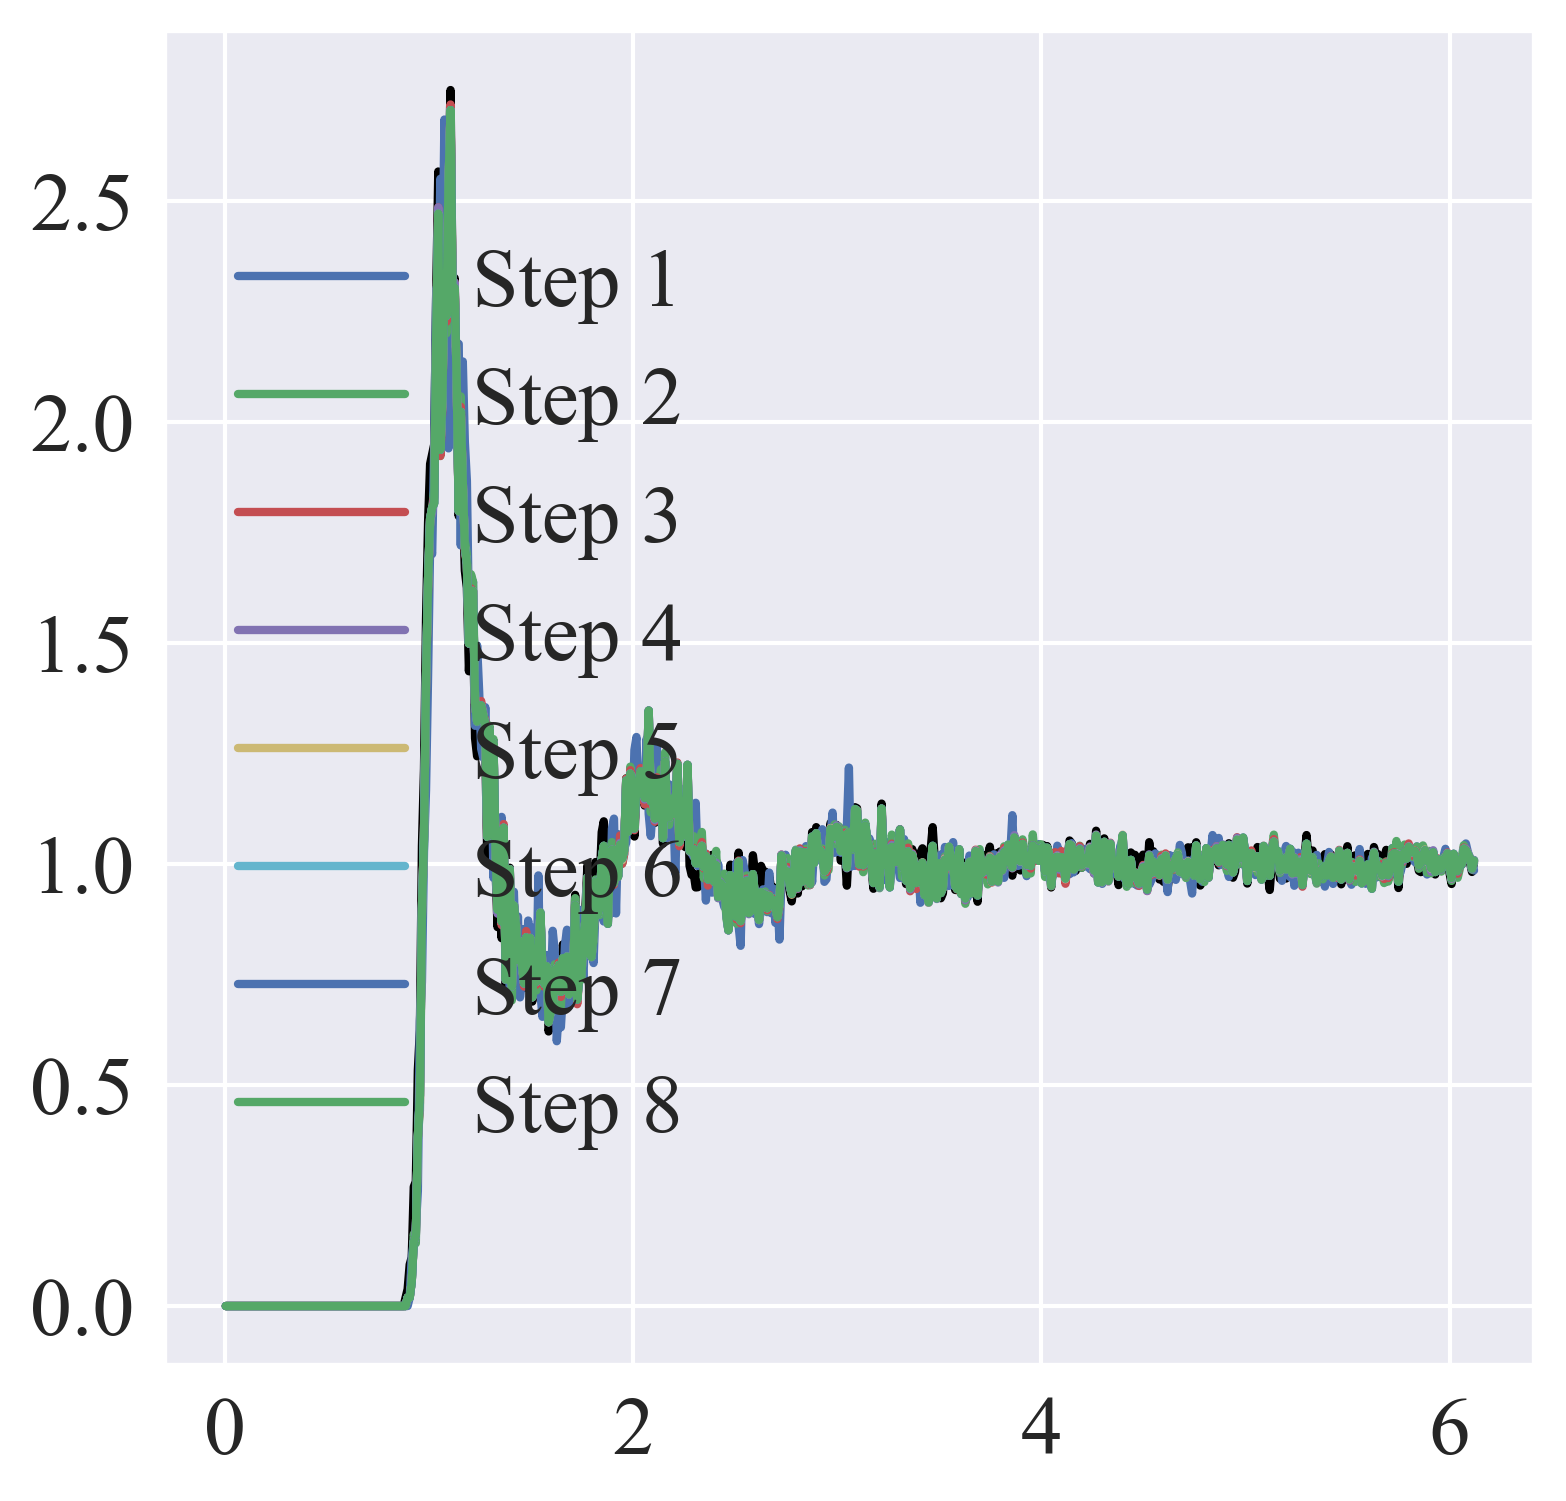

In [24]:
plt.plot(radii, obs_rdf, color='black')
for i, parameters in enumerate(parameters_array):
    plt.plot(
        radii, 
        calculate_rdf(parameters)[1], 
        label=f'Step {i + 1}',
    )
plt.legend()
plt.show()

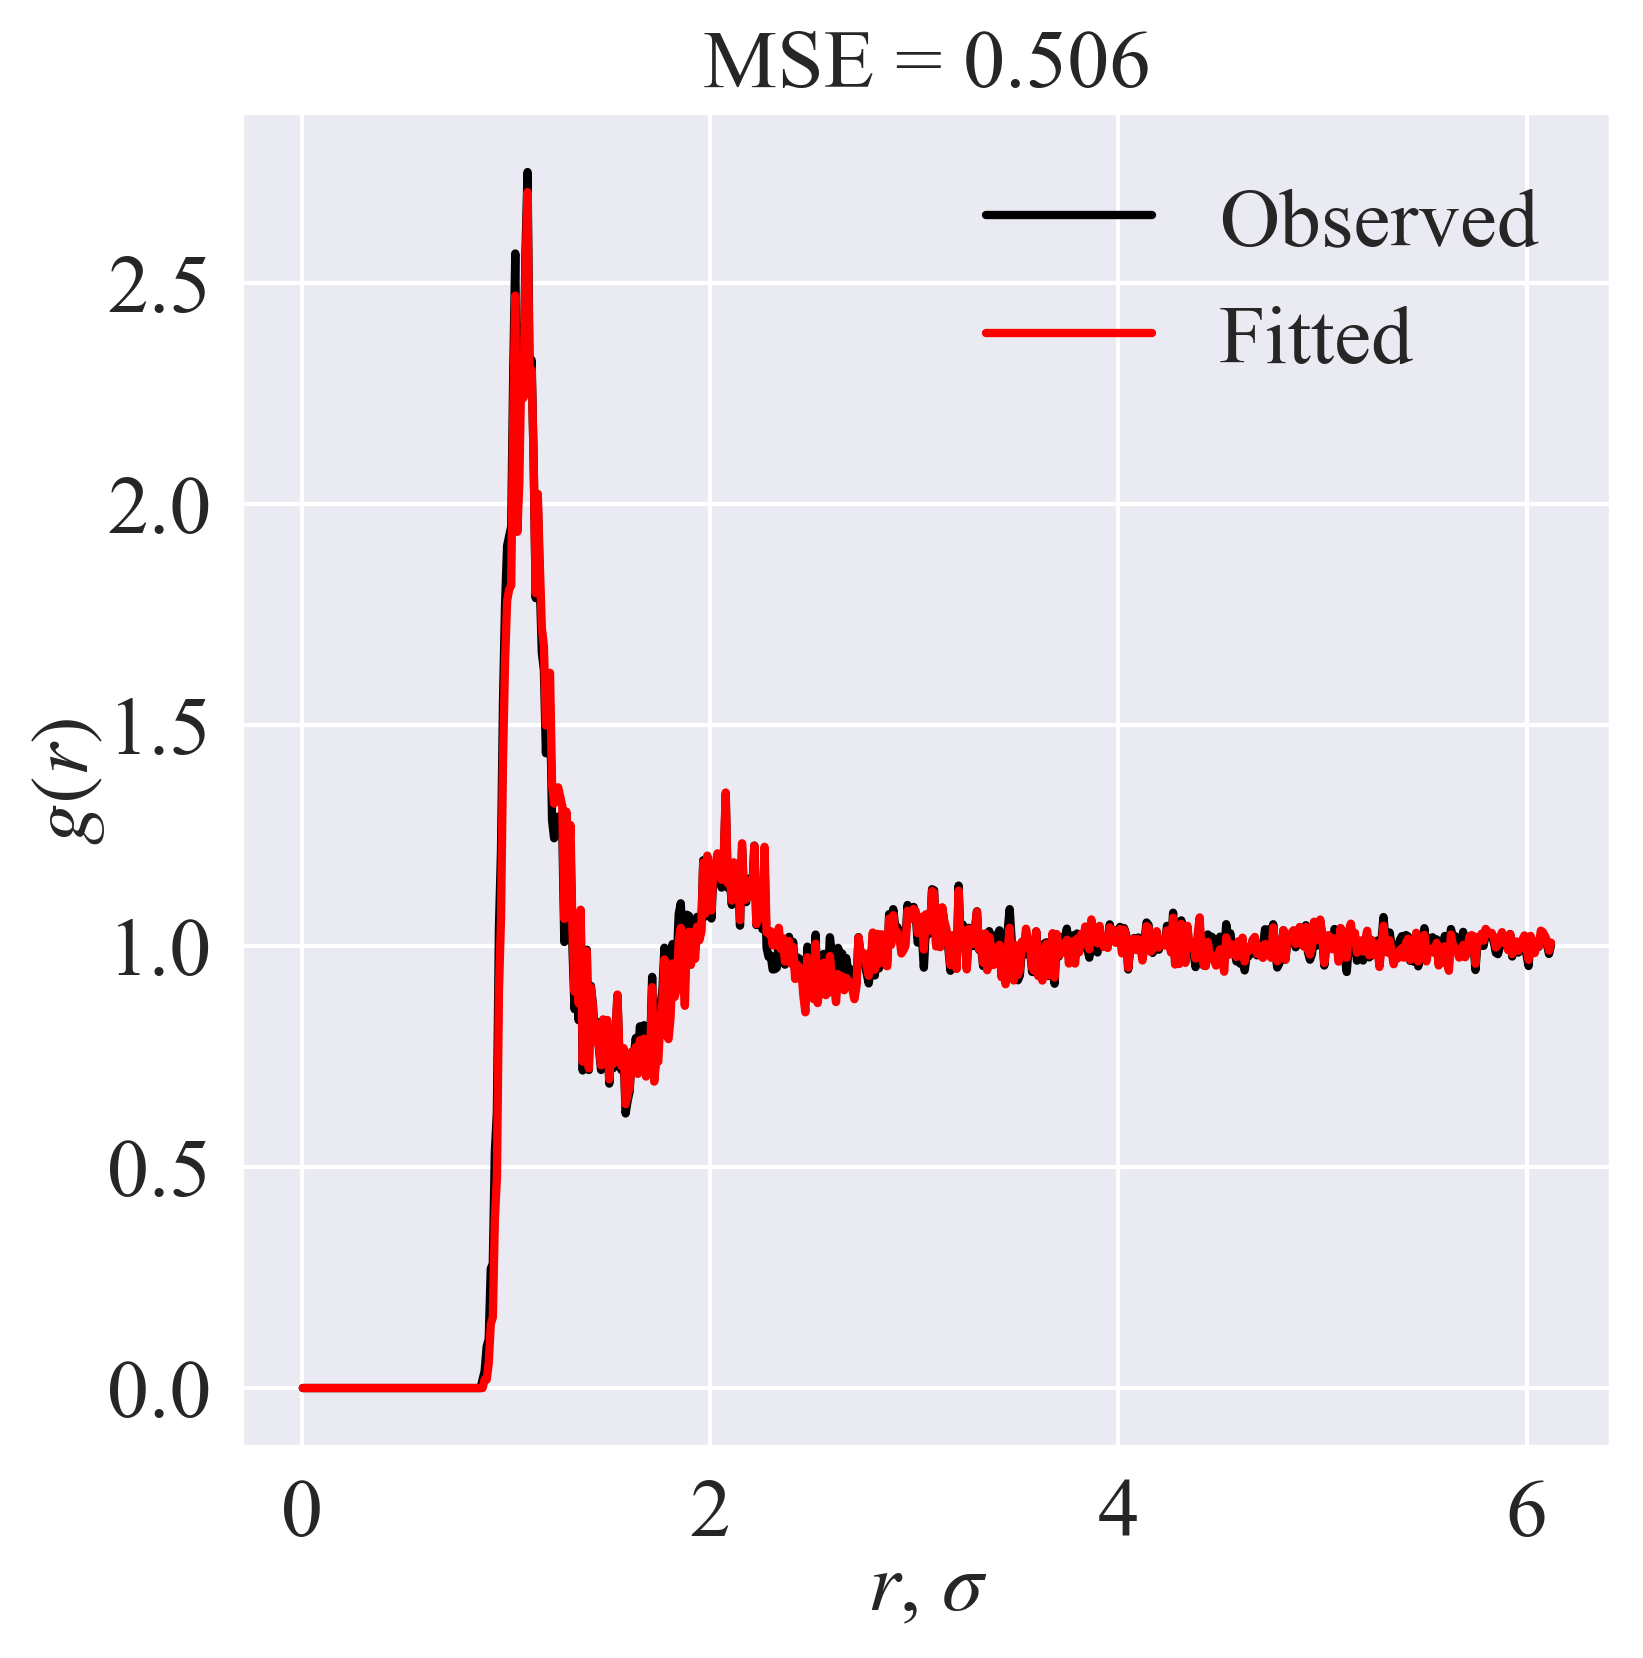

In [25]:
plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, new_exp_rdf, color='red', label='Fitted')

plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=new_exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('optimized_state_local.png')
plt.show()

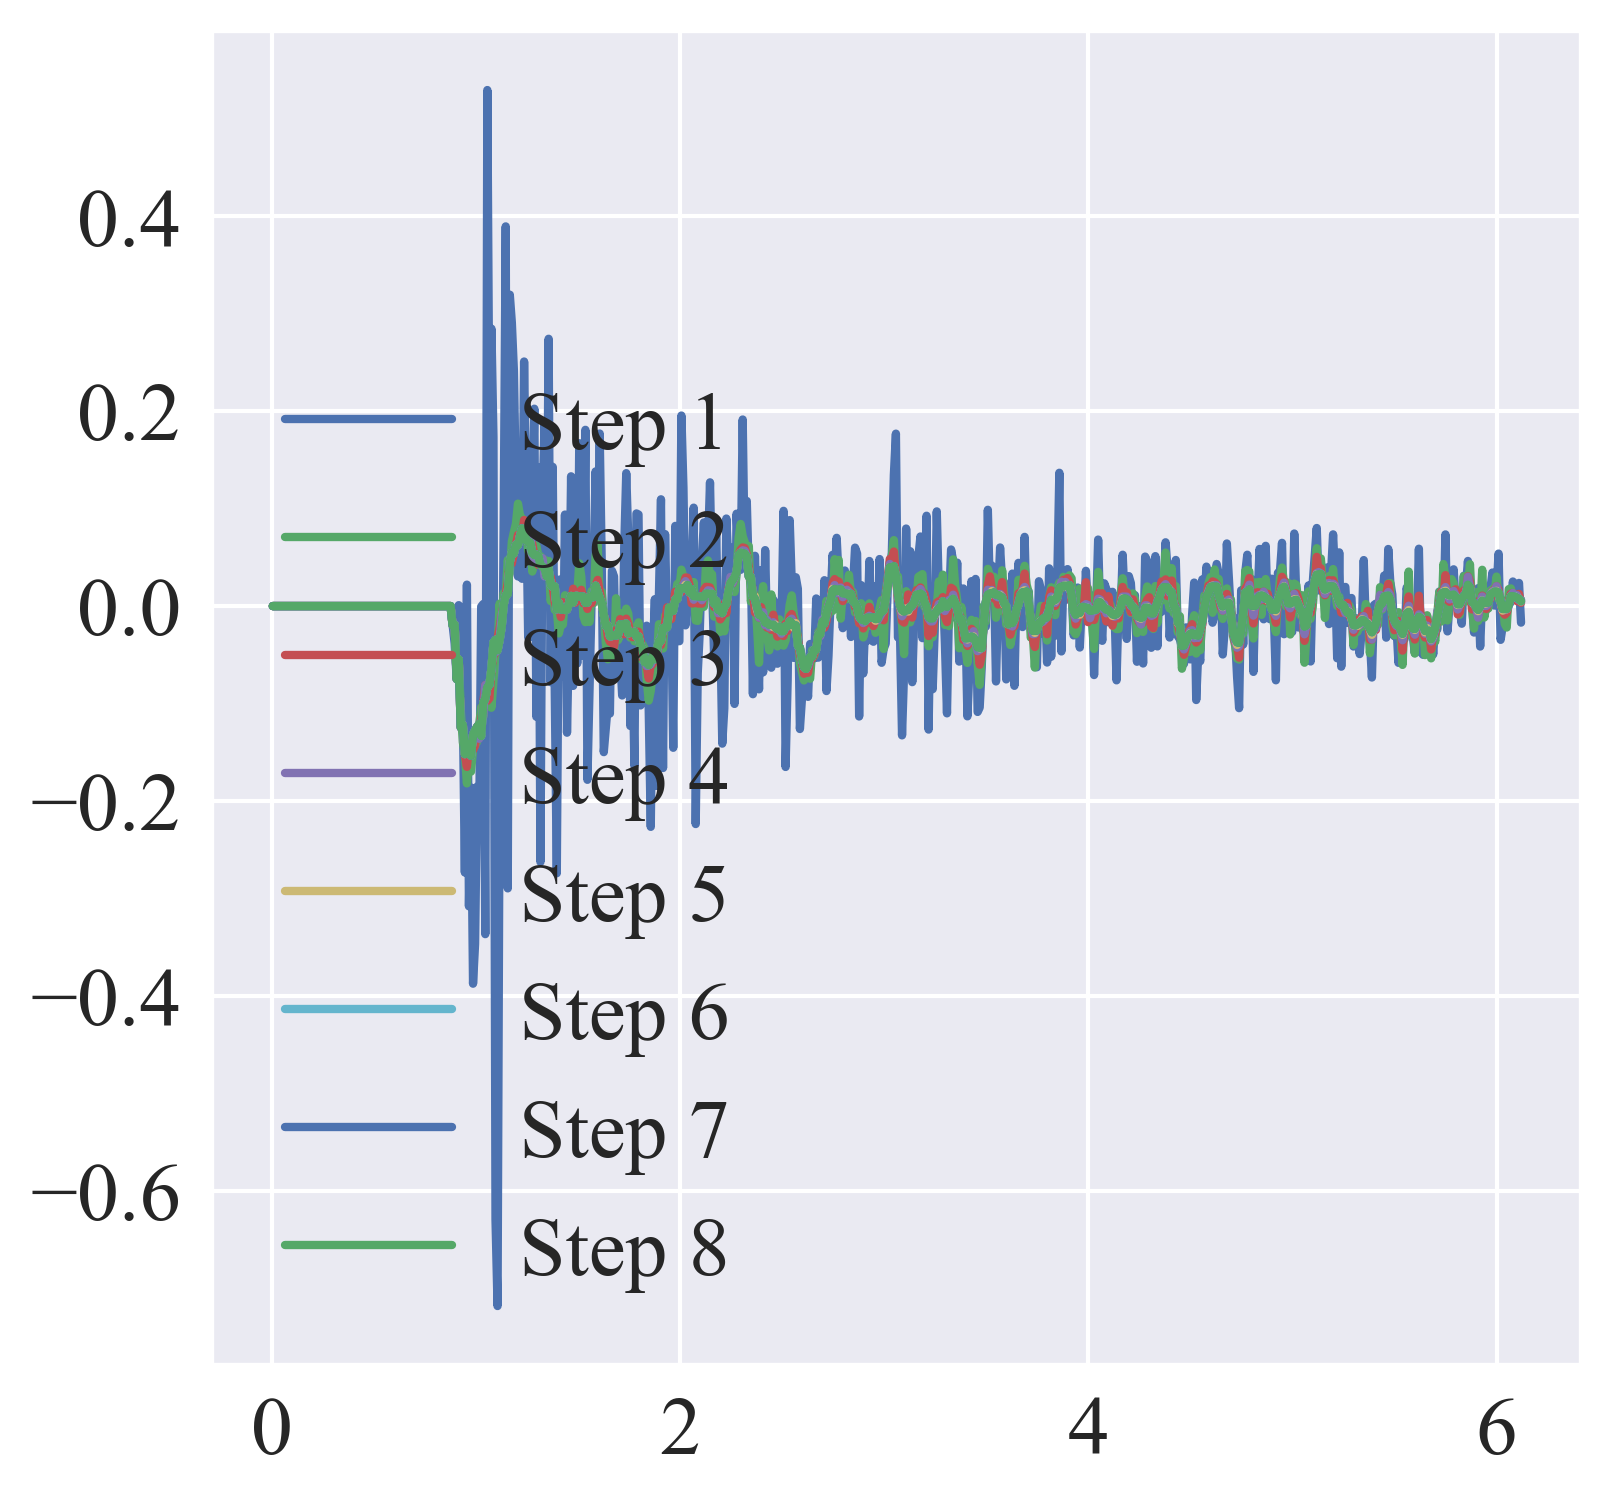

In [26]:
for i, parameters in enumerate(parameters_array):
    plt.plot(
        radii, 
        calculate_rdf(parameters)[1] - obs_rdf, 
        label=f'Step {i + 1}',
    )
plt.legend()
plt.show()

In [27]:
some_positions

array([[ 5.77046259, -5.24812766, -2.35330869],
       [ 0.26348787,  0.23353462,  5.26542035],
       [ 1.55456027,  0.86504747,  0.81226249],
       ...,
       [-0.52255611,  4.06050458, -4.73555708],
       [ 6.00386276,  2.88401089,  5.16811926],
       [-2.25294797,  4.39762752, -5.60429382]])

In [28]:
new_positions

array([[ 5.78046259, -5.25012766, -2.36330869],
       [ 0.25348787,  0.23553462,  5.26742035],
       [ 1.54616027,  0.87704747,  0.81434249],
       ...,
       [-0.52055611,  4.06050458, -4.73555708],
       [ 6.00586276,  2.88401089,  5.15851926],
       [-2.25262797,  4.39762752, -5.60421382]])

In [29]:
cell_dimensions = np.ones(3) * 12.25
ovito_1 = OvitoProcessor(positions=some_positions, cell_dimensions=cell_dimensions)
ovito_2 = OvitoProcessor(positions=new_positions, cell_dimensions=cell_dimensions)

In [30]:
indices_1 = get_unique_frame(ovito_1.get_voronoi_indices())
indices_2 = get_unique_frame(ovito_2.get_voronoi_indices())
for i in range(10):
    if i not in indices_1.columns:
        indices_1[i] = 0
    if i not in indices_2.columns:
        indices_2[i] = 0
merged_indices = indices_1.merge(
    right=indices_2, 
    on=list(range(10)), 
    how='outer',
).fillna(0).astype(int)
merged_indices['diff'] = merged_indices['counts_y'] - merged_indices['counts_x']
merged_indices

,counts_x,0,1,2,3,4,5,6,7,8,9,counts_y,diff
0,17,0,0,1,4,5,3,0,0,0,0,10,-7
1,14,0,0,1,3,5,4,0,0,0,0,17,3
2,11,0,0,0,3,6,3,0,0,0,0,11,0
3,11,0,0,0,4,6,2,0,0,0,0,7,-4
4,11,0,0,0,3,6,4,0,0,0,0,9,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,0,0,0,2,1,8,2,0,0,1,0,1,1
1109,0,0,0,2,2,4,3,1,0,0,0,1,1
1110,0,0,0,2,2,3,2,3,0,0,0,1,1
1111,0,0,0,2,2,4,2,1,1,0,0,1,1


In [31]:
volumes_1 = get_unique_frame(ovito_1.get_voronoi_volumes()).rename(columns={0: 'volume'})
volumes_2 = get_unique_frame(ovito_2.get_voronoi_volumes()).rename(columns={0: 'volume'})
merged_volumes = volumes_1.merge(
    right=volumes_2, 
    on='volume', 
    how='outer',
).fillna(0)
merged_volumes['diff'] = merged_volumes['counts_y'] - merged_volumes['counts_x']
merged_volumes

,counts_x,volume,counts_y,diff
0,1.0,0.922137,0.0,-1.0
1,1.0,1.388285,0.0,-1.0
2,1.0,1.390084,0.0,-1.0
3,1.0,1.389975,0.0,-1.0
4,1.0,1.389873,0.0,-1.0
...,...,...,...,...
2739,0.0,1.256856,1.0,1.0
2740,0.0,1.256764,1.0,1.0
2741,0.0,1.256669,1.0,1.0
2742,0.0,1.256260,1.0,1.0


In [32]:
coordinations_1 = get_unique_frame(ovito_1.get_voronoi_coordination()).rename(columns={0: 'coordination'})
coordinations_2 = get_unique_frame(ovito_2.get_voronoi_coordination()).rename(columns={0: 'coordination'})
merged_coordinations = coordinations_1.merge(
    right=coordinations_2, 
    on='coordination', 
    how='outer',
).fillna(0).astype(int)
merged_coordinations['diff'] = merged_coordinations['counts_y'] - merged_coordinations['counts_x']
merged_coordinations

,counts_x,coordination,counts_y,diff
0,339,14,337,-2
1,322,13,320,-2
2,250,15,262,12
3,176,12,178,2
4,136,16,129,-7
5,76,11,73,-3
6,56,17,53,-3
7,10,18,12,2
8,5,10,6,1
9,2,19,2,0


In [33]:
merged_indices = merged_indices[
    (merged_indices['counts_x'] > 1)
    & (merged_indices['counts_y'] > 1)
].reset_index(drop=True)
merged_indices

,counts_x,0,1,2,3,4,5,6,7,8,9,counts_y,diff
0,17,0,0,1,4,5,3,0,0,0,0,10,-7
1,14,0,0,1,3,5,4,0,0,0,0,17,3
2,11,0,0,0,3,6,3,0,0,0,0,11,0
3,11,0,0,0,4,6,2,0,0,0,0,7,-4
4,11,0,0,0,3,6,4,0,0,0,0,9,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,2,0,0,0,2,8,3,0,0,0,0,2,0
173,2,0,0,0,3,6,5,0,0,0,0,2,0
174,2,0,0,1,3,6,5,1,0,0,0,2,0
175,2,0,0,0,3,6,2,0,0,0,0,3,1


In [34]:
merged_indices['diff'].describe()

count    177.000000
mean      -0.090395
std        1.357960
min       -7.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: diff, dtype: float64

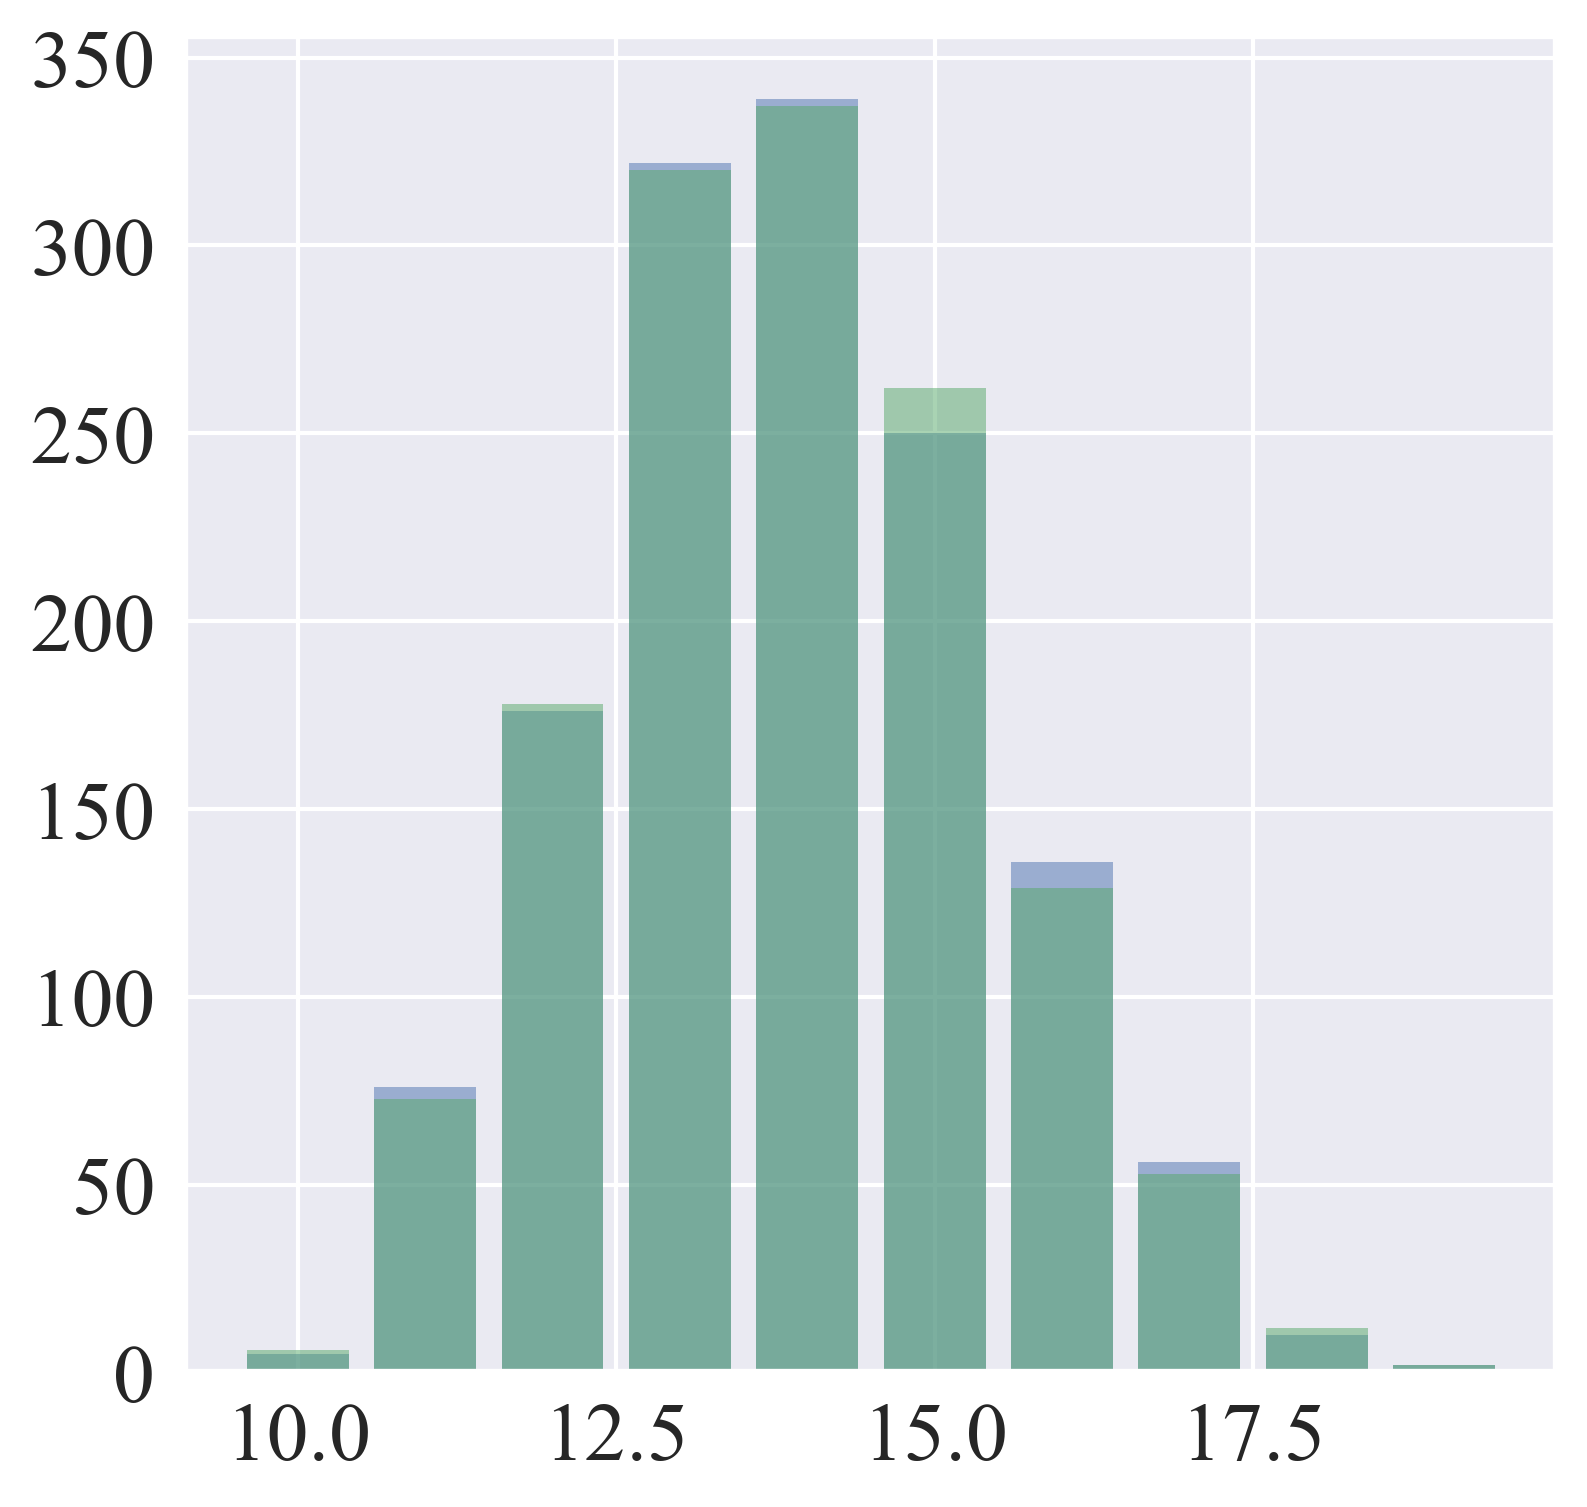

In [35]:
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_x'], alpha=0.5)
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_y'], alpha=0.5)
plt.show()

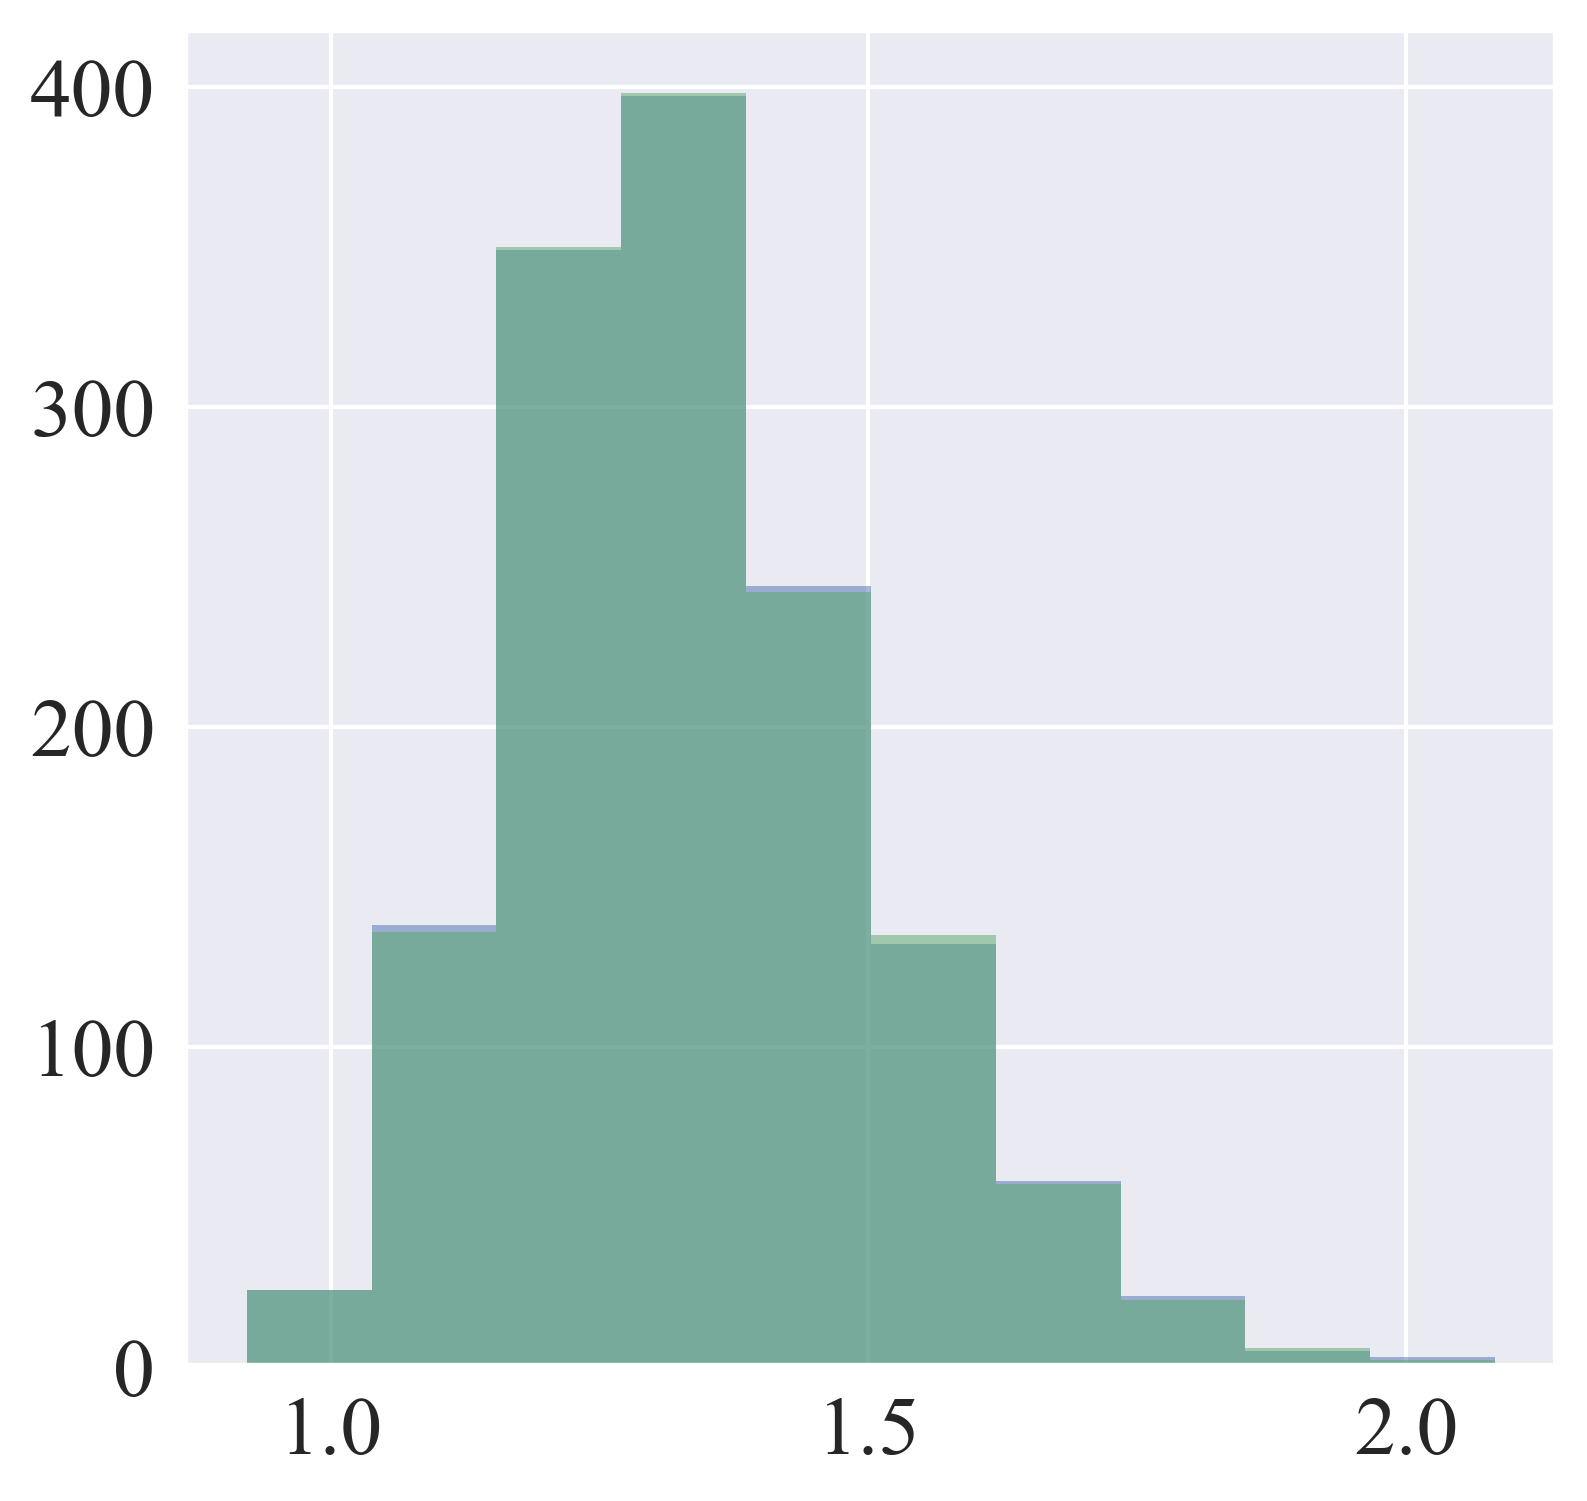

In [36]:
hist, bins, _ = plt.hist(volumes_1['volume'], alpha=0.5)
plt.hist(volumes_2['volume'], alpha=0.5, bins=bins)
plt.show()

In [37]:
radii, ovito_rdf_1, coordination_1 = ovito_1.get_rdf(is_coordination_returned=True)
radii, ovito_rdf_2, coordination_2 = ovito_2.get_rdf(is_coordination_returned=True)

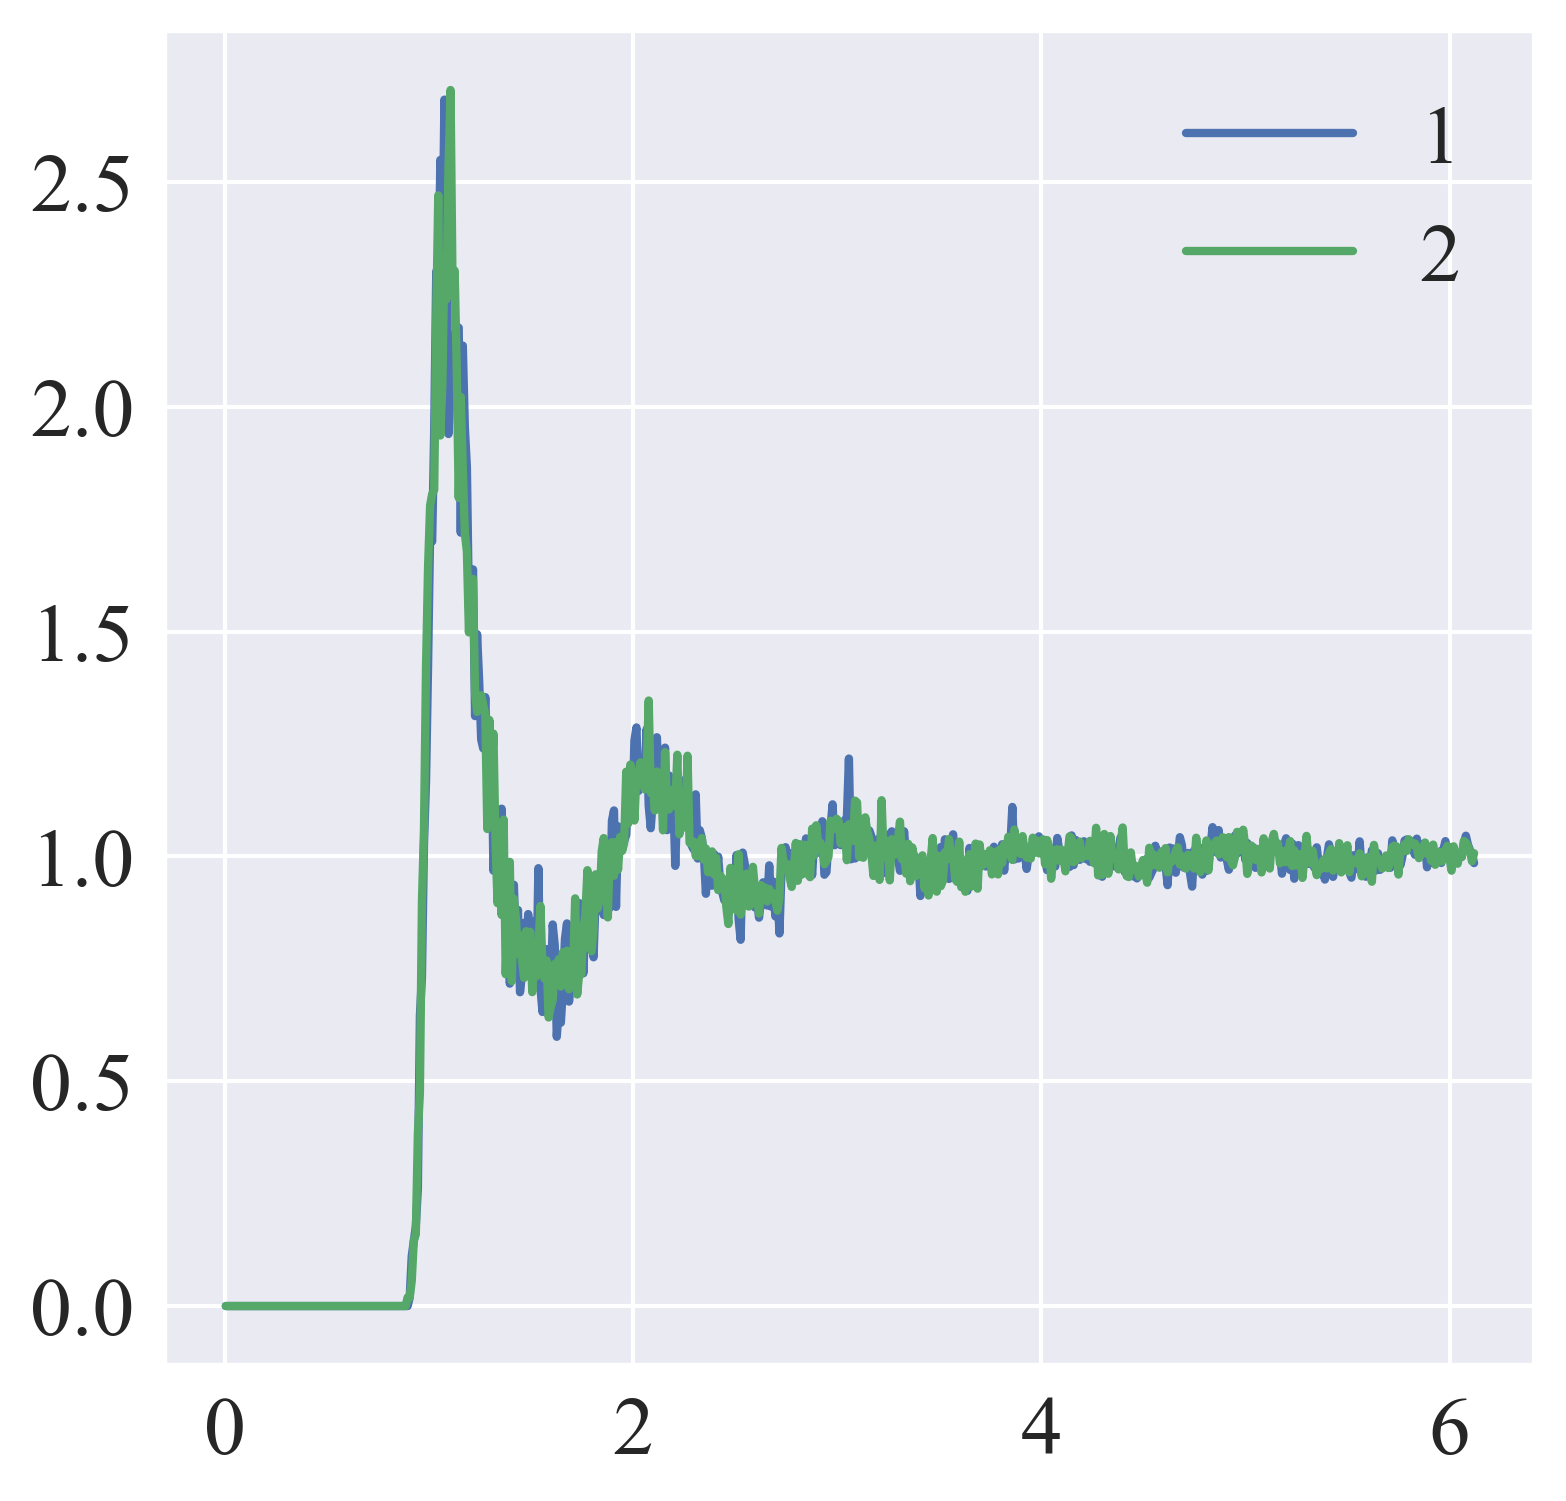

In [38]:
plt.plot(radii, ovito_rdf_1, label='1')
plt.plot(radii, ovito_rdf_2, label='2')
plt.legend()
plt.show()

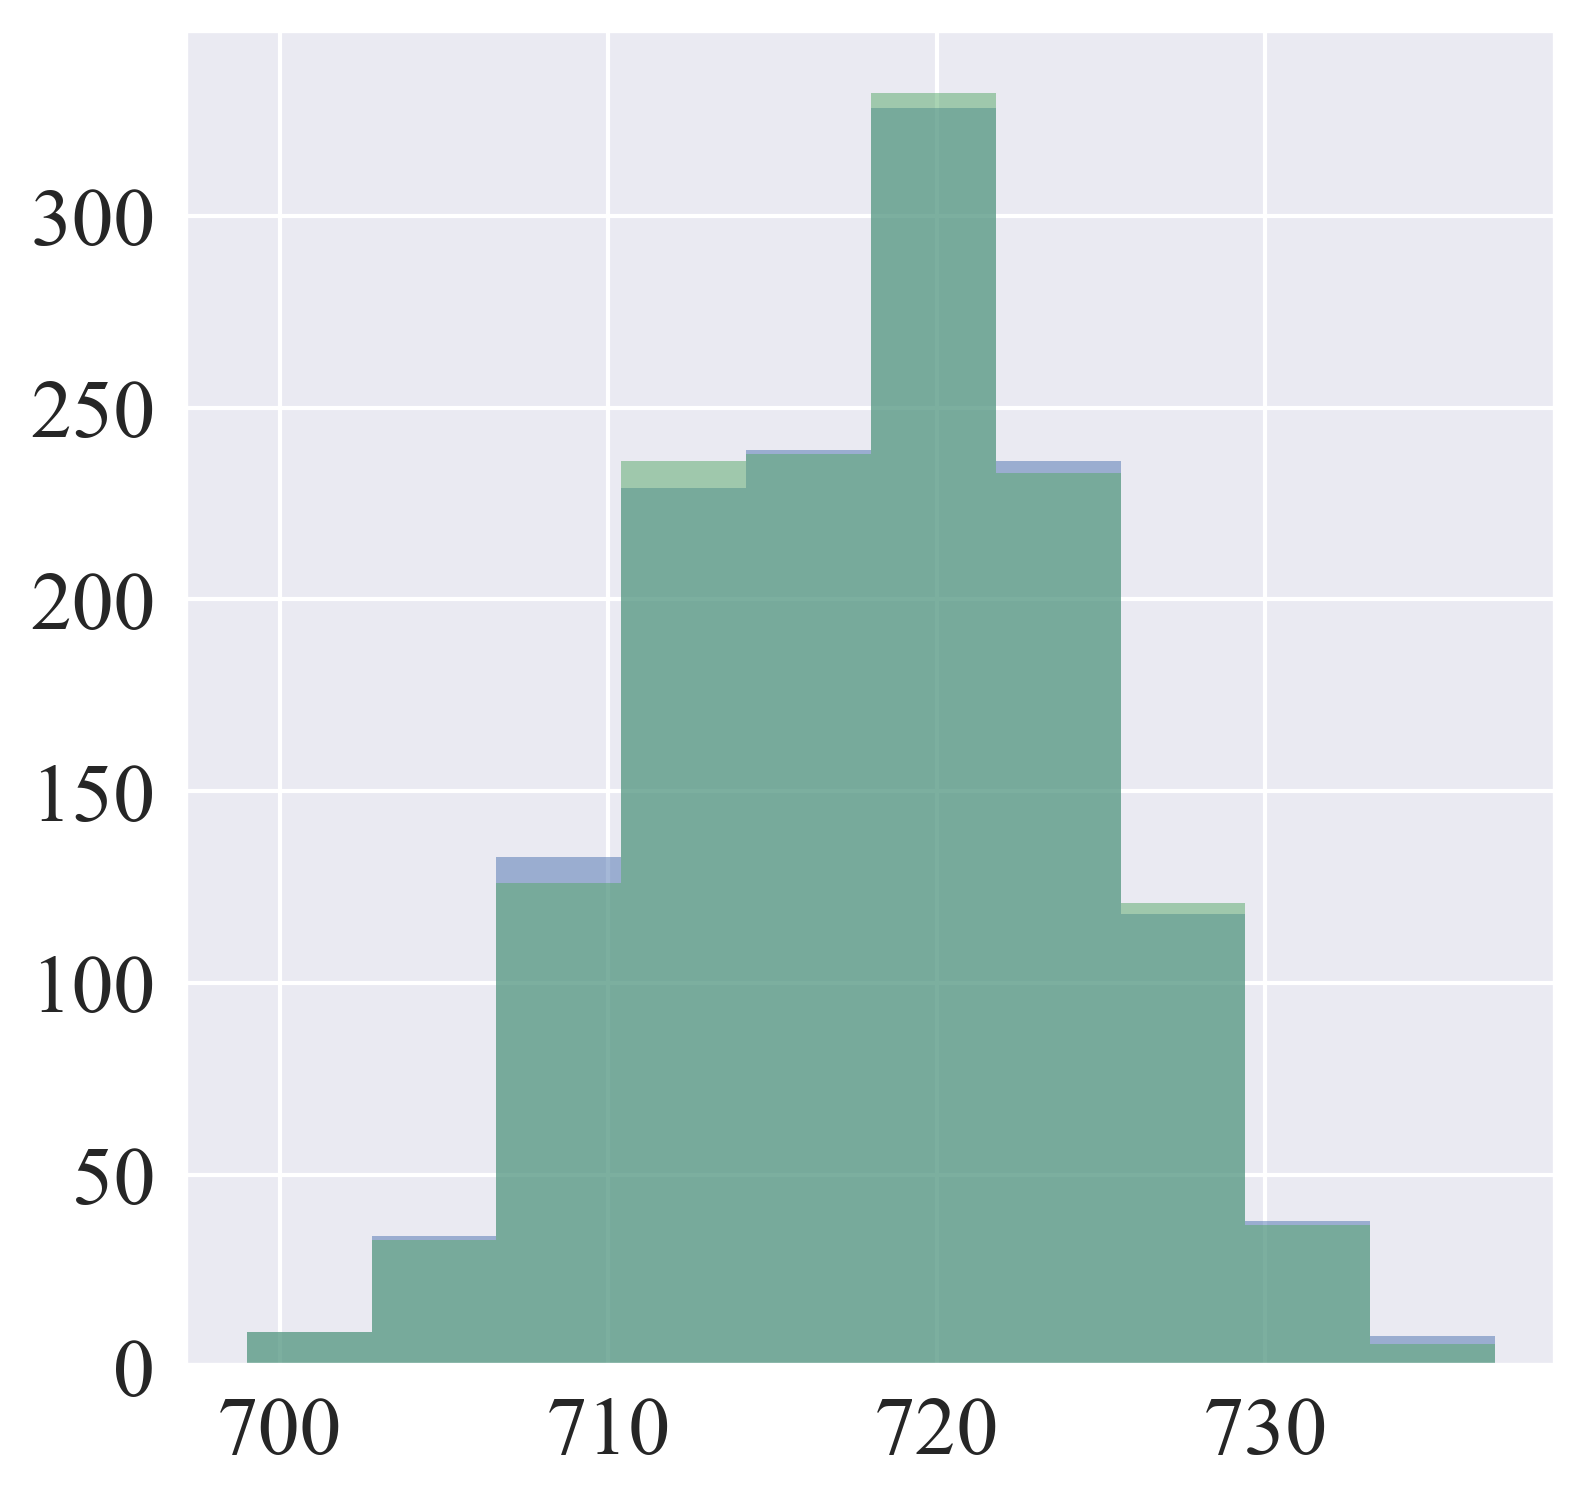

In [39]:
hist, bins, _ = plt.hist(coordination_1, alpha=0.5)
plt.hist(coordination_2, alpha=0.5, bins=bins)
plt.show()

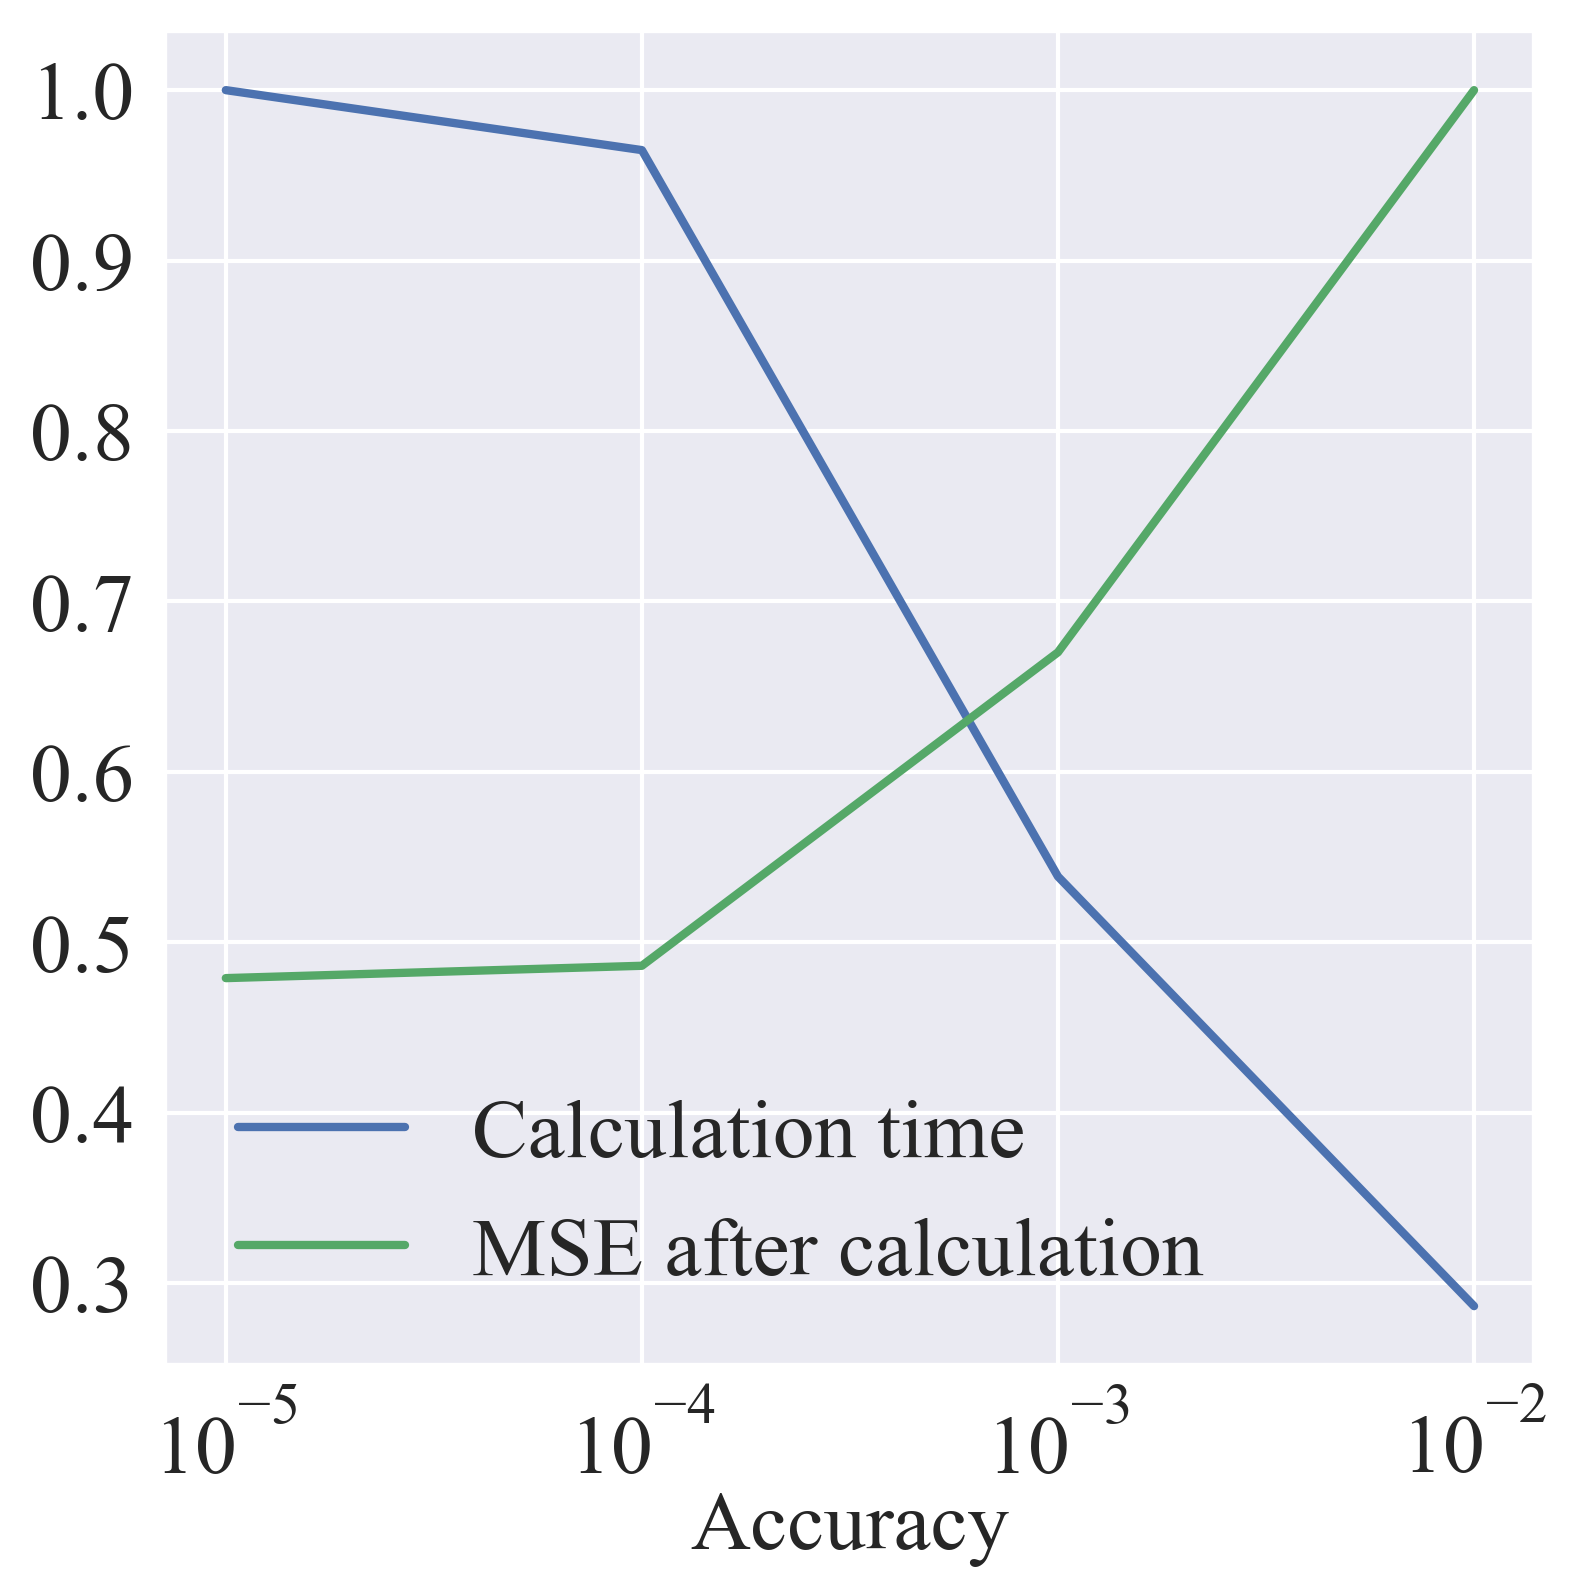

In [40]:
accuracies = np.array([1e-2, 1e-3, 1e-4, 1e-5])
times = np.array([291.500393, 547.916789, 981.426485, 1017.221477])
errors = np.array([0.1990364055106134, 0.13339311228418615, 0.0967833879874992, 0.09534158842519781])

plt.plot(accuracies, times / times.max(), label='Calculation time')
plt.plot(accuracies, errors / errors.max(), label='MSE after calculation')
plt.xscale('log')
plt.xlabel('Accuracy')
plt.legend()
plt.show()